# 3D FISH PWS Paper Analysis and Figures
## Notebook Created by Jane Frederick

# Import Packages

In [1]:
import os
import glob
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statsmodels.stats.multicomp as mc

# Plot Settings

In [2]:
import seaborn.categorical
seaborn.categorical._Old_Violin = seaborn.categorical._ViolinPlotter

class _My_ViolinPlotter(seaborn.categorical._Old_Violin):

    def __init__(self, *args, **kwargs):
        super(_My_ViolinPlotter, self).__init__(*args, **kwargs)
        self.gray='k'

seaborn.categorical._ViolinPlotter = _My_ViolinPlotter

import seaborn as sns

sns.set(style='ticks',palette='colorblind',context='paper',font_scale=2)
colorblindpal = sns.color_palette('colorblind')

# mpl.font_manager._load_fontmanager(try_read_cache=False)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['axes.edgecolor'] = 'k'
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['errorbar.capsize'] = 2.5
mpl.rcParams['legend.frameon'] = False

D_plot_lim = [1.475,3.1]
PLOS_ONE_fig_width_max = 5.2
PLOS_ONE_fig_height_max = 8.75

plot_pal = {'Full FISH Protocol':'lightsteelblue','Individual FISH Reagents':'steelblue',
           'Live':'slategrey','Live Cells':'slategrey'}

# Read Data

In [3]:
paperfolder = '\\OneDrive - Northwestern University\\Documents - Backman Lab - Shared Folders\\Lab Paper Drafts'
parent_folder = glob.glob('C:\\Users\\**'+paperfolder)[0]+'\\FISH vs. CRISPR'
main_dir = parent_folder + '\\PLOS ONE Revision Files'
save_dir = main_dir + '\\Revised Figures\\Plots'

all_data = pd.read_csv(main_dir+'\\Average Nuclear PWS Data.csv')
all_hist = pd.read_csv(main_dir+'\\D Pixel Histogram Data.csv')
all_eff = pd.read_csv(main_dir+'\\Flow Cytometry Data.csv')
all_foci = pd.read_csv(main_dir+'\\Confocal Foci Data.csv')

# Cumulative FISH Protocol vs. Treatment with Individual Reagents

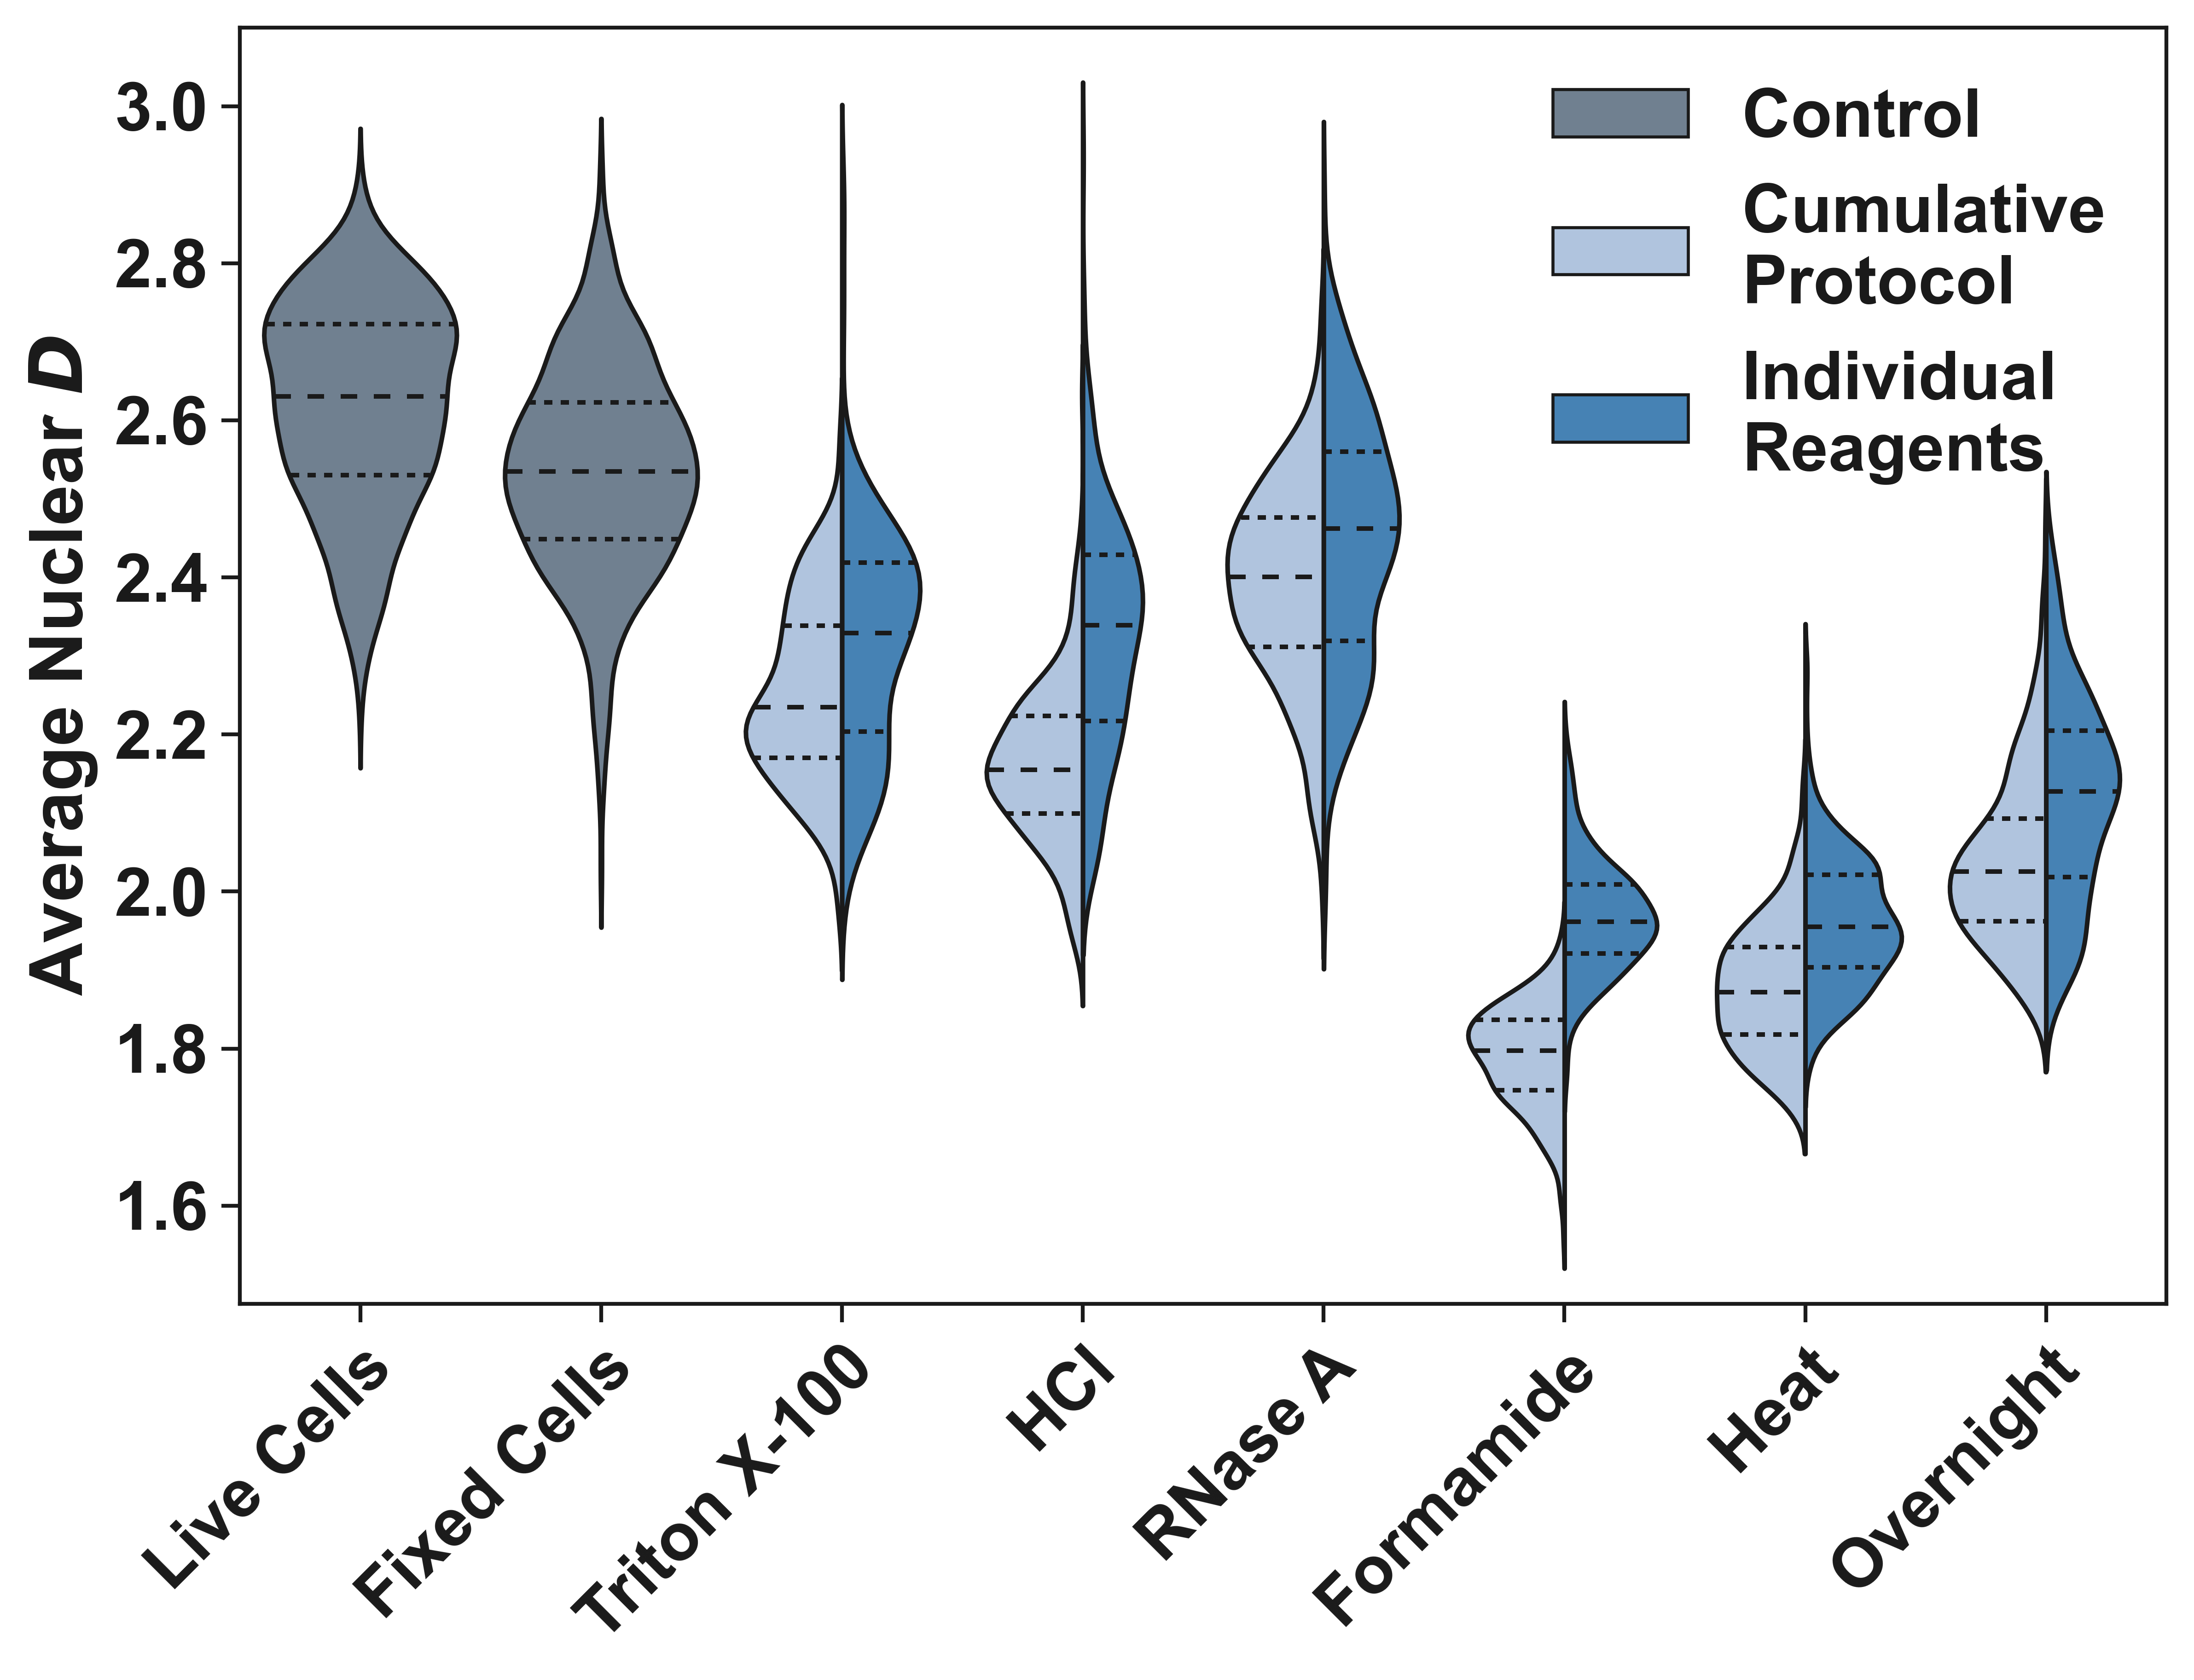

In [4]:
fish_fig = all_data[(all_data.Experiment=='Full 3D FISH Protocol')|
                    (all_data.Experiment=='Individual 3D FISH Reagents')].copy()
fish_order = ['Live','PFA','Triton X-100','HCl','RNase A','Formamide','Heat','Overnight']
fish_pal = {'Full 3D FISH Protocol':'lightsteelblue','Individual 3D FISH Reagents':'steelblue'}

split_plot = fish_fig.copy()
split_plot.loc[(split_plot.Condition=='Live')|(split_plot.Condition=='PFA'),'D'] = np.nan

fig, ax = plt.subplots(figsize=[9,6])
sns.violinplot(data=fish_fig[fish_fig.Condition=='Live'],x='Condition',y='D',inner='quart',saturation=1,ax=ax,
              order=fish_order,color=plot_pal['Live'])
sns.violinplot(data=fish_fig[fish_fig.Condition=='PFA'],x='Condition',y='D',inner='quart',saturation=1,ax=ax,
              order=fish_order,color=plot_pal['Live'])
sns.violinplot(data=split_plot,x='Condition',y='D',hue='Experiment',split=True,inner='quart',saturation=1,
               ax=ax,palette=fish_pal)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Live Cells'
labels[1] = 'Fixed Cells'
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylim(D_plot_lim)
ax.set_xlabel('')
ax.set_ylabel(r'Average Nuclear $D$')
l_h = [mpl.patches.Patch(facecolor='slategray', edgecolor='k',label='Control'),
       mpl.patches.Patch(facecolor='lightsteelblue', edgecolor='k',label='Cumulative\nProtocol'),
       mpl.patches.Patch(facecolor='steelblue', edgecolor='k',label='Individual\nReagents')]
legend = plt.legend(handles=l_h,title='')
plt.show()
fig.savefig(save_dir+'\\FISH Protocol PWS.pdf',dpi=600,transparent=True,bbox_inches='tight')

In [5]:
fish_fig['Sample'] = fish_fig['Experiment']+' '+fish_fig['Condition'].astype('str')
fish_fig.loc[fish_fig.Sample.str.contains('Live'),'Sample'] = 'Live'
fish_fig.loc[fish_fig.Sample.str.contains('PFA'),'Sample'] = 'PFA'

fish_table_columns = ['Condition','N Full','N Ind','Mean D Full','Mean D Ind','STD D Full','STD D Ind',
                      'Live Delta D Full','Live Delta D Ind','Fixed Delta D Full','Fixed Delta D Ind',
                      'Delta D Between','Live Percent Change Full','Live Percent Change Ind',
                      'Fixed Percent Change Full','Fixed Percent Change Ind','Percent Diff Between','Live Pval Full',
                      'Live Pval Corr Full','Fixed Pval Full','Fixed Pval Corr Full','Live Pval Ind',
                      'Live Pval Corr Ind','Fixed Pval Ind','Fixed Pval Corr Ind','Pval Between','Pval Corr Between']
fish_table = pd.DataFrame(columns=fish_table_columns)
fish_table['Condition'] = fish_fig.Condition.unique()

full_prot = fish_fig[fish_fig.Experiment=='Full 3D FISH Protocol'].copy()
full_prot['Condition'] = pd.Categorical(full_prot['Condition'],categories=fish_fig.Condition.unique())
full_prot.sort_values('Condition',inplace=True)
ind_reag = fish_fig[fish_fig.Experiment=='Individual 3D FISH Reagents'].copy()
ind_reag['Condition'] = pd.Categorical(ind_reag['Condition'],categories=fish_fig.Condition.unique())
ind_reag.sort_values('Condition',inplace=True)

fish_table['N Full'] = full_prot.groupby('Condition').describe()['D','count'].values.astype(int)
fish_table['N Ind'] = ind_reag.groupby('Condition').describe()['D','count'].values.astype(int) 
fish_table['Mean D Full'] = full_prot.groupby('Condition').describe()['D','mean'].values
fish_table['Mean D Ind'] = ind_reag.groupby('Condition').describe()['D','mean'].values
fish_table.loc[fish_table.Condition=='Live',['N Full','N Ind']] = fish_fig.groupby('Condition').D.count()['Live']
fish_table.loc[fish_table.Condition=='Live',['Mean D Full',
                                                'Mean D Ind']] = fish_fig.groupby('Condition').D.mean()['Live']
fish_table.loc[fish_table.Condition=='PFA',['N Full','N Ind']] = fish_fig.groupby('Condition').D.count()['PFA']
fish_table.loc[fish_table.Condition=='PFA',['Mean D Full',
                                            'Mean D Ind']] = fish_fig.groupby('Condition').D.mean()['PFA']

full_prot_ctrl = fish_table.loc[fish_table.Condition=='Live','Mean D Full'].item()
ind_reag_ctrl = fish_table.loc[fish_table.Condition=='Live','Mean D Ind'].item()
full_prot_fix = fish_table.loc[fish_table.Condition=='PFA','Mean D Full'].item()
ind_reag_fix = fish_table.loc[fish_table.Condition=='PFA','Mean D Ind'].item()
fish_table['STD D Full'] = full_prot.groupby('Condition').describe()['D','std'].values
fish_table['STD D Ind'] = ind_reag.groupby('Condition').describe()['D','std'].values
fish_table.loc[fish_table.Condition=='Live',['STD D Full',
                                                'STD D Ind']] = fish_fig.groupby('Condition').D.std()['Live']
fish_table.loc[fish_table.Condition=='PFA',['STD D Full','STD D Ind']] = fish_fig.groupby('Condition').D.std()['PFA']

fish_table['Live Delta D Full'] = fish_table['Mean D Full']-full_prot_ctrl
fish_table['Live Delta D Ind'] = fish_table['Mean D Ind']-ind_reag_ctrl
fish_table['Fixed Delta D Full'] = fish_table['Mean D Full']-full_prot_fix
fish_table['Fixed Delta D Ind'] = fish_table['Mean D Ind']-ind_reag_fix
fish_table['Delta D Between'] = (fish_table['Mean D Full']-fish_table['Mean D Ind']).abs()
fish_table['Live Percent Change Full'] = fish_table['Live Delta D Full']/full_prot_ctrl*100
fish_table['Live Percent Change Ind'] = fish_table['Live Delta D Ind']/ind_reag_ctrl*100
fish_table['Fixed Percent Change Full'] = fish_table['Fixed Delta D Full']/full_prot_fix*100
fish_table['Fixed Percent Change Ind'] = fish_table['Fixed Delta D Ind']/ind_reag_fix*100
fish_table['Percent Diff Between'] = fish_table['Delta D Between']/((fish_table['Mean D Full']+
                                                                     fish_table['Mean D Ind'])/2)*100

fish_comp = mc.MultiComparison(fish_fig['D'], fish_fig['Sample'])
tbl, a1, a2 = fish_comp.allpairtest(stats.ttest_ind, method= 'bonf')
fish_stats = pd.read_html(tbl.as_html(),header=0)[0]

full_prot_stats = fish_stats[((fish_stats['group1']=='Live')|(fish_stats['group2']=='Live'))&
                        ((fish_stats['group1'].str.contains('Full 3D FISH Protocol'))|
                         (fish_stats['group2'].str.contains('Full 3D FISH Protocol')))].copy()
full_prot_stats.loc[fish_stats['group1']!='Live',
                   ['group1','group2']] = full_prot_stats.loc[fish_stats['group1']!='Live',['group2','group1']].values
full_prot_stats['group2'] = pd.Categorical(full_prot_stats['group2'],categories=full_prot.Sample.unique())
full_prot_stats.sort_values('group2',inplace=True)

ind_reag_stats = fish_stats[((fish_stats['group1']=='Live')|(fish_stats['group2']=='Live'))&
                        ((fish_stats['group1'].str.contains('Ind'))|
                         (fish_stats['group2'].str.contains('Ind')))].copy()
ind_reag_stats.loc[fish_stats['group1']!='Live',
                   ['group1','group2']] = ind_reag_stats.loc[fish_stats['group1']!='Live',['group2','group1']].values
ind_reag_stats['group2'] = pd.Categorical(ind_reag_stats['group2'],categories=ind_reag.Sample.unique())
ind_reag_stats.sort_values('group2',inplace=True)

fish_table['Live Pval Full'] = np.insert(pd.DataFrame(a1[0][full_prot_stats.index])[1].values,[0,0],math.nan)
fish_table['Live Pval Ind'] = np.insert(pd.DataFrame(a1[0][ind_reag_stats.index])[1].values,[0,0],math.nan)
fish_table['Live Pval Corr Full'] = np.insert(a1[2][full_prot_stats.index],[0,0],math.nan)
fish_table['Live Pval Corr Ind'] = np.insert(a1[2][ind_reag_stats.index],[0,0],math.nan)

full_prot_stats = fish_stats[((fish_stats['group1']=='PFA')|(fish_stats['group2']=='PFA'))&
                        ((fish_stats['group1'].str.contains('Full 3D FISH Protocol'))|
                         (fish_stats['group2'].str.contains('Full 3D FISH Protocol')))].copy()
full_prot_stats.loc[fish_stats['group1']!='PFA',
                   ['group1','group2']] = full_prot_stats.loc[fish_stats['group1']!='PFA',['group2','group1']].values
full_prot_stats['group2'] = pd.Categorical(full_prot_stats['group2'],categories=full_prot.Sample.unique())
full_prot_stats.sort_values('group2',inplace=True)

ind_reag_stats = fish_stats[((fish_stats['group1']=='PFA')|(fish_stats['group2']=='PFA'))&
                        ((fish_stats['group1'].str.contains('Ind'))|
                         (fish_stats['group2'].str.contains('Ind')))].copy()
ind_reag_stats.loc[fish_stats['group1']!='PFA',
                   ['group1','group2']] = ind_reag_stats.loc[fish_stats['group1']!='PFA',['group2','group1']].values
ind_reag_stats['group2'] = pd.Categorical(ind_reag_stats['group2'],categories=ind_reag.Sample.unique())
ind_reag_stats.sort_values('group2',inplace=True)

fish_table['Fixed Pval Full'] = np.insert(pd.DataFrame(a1[0][full_prot_stats.index])[1].values,[0,0],math.nan)
fish_table['Fixed Pval Ind'] = np.insert(pd.DataFrame(a1[0][ind_reag_stats.index])[1].values,[0,0],math.nan)
fish_table['Fixed Pval Corr Full'] = np.insert(a1[2][full_prot_stats.index],[0,0],math.nan)
fish_table['Fixed Pval Corr Ind'] = np.insert(a1[2][ind_reag_stats.index],[0,0],math.nan)

pfa_ind = fish_stats[((fish_stats['group1']=='Live')|(fish_stats['group2']=='Live'))&
                     ((fish_stats['group1']=='PFA')|(fish_stats['group2']=='PFA'))].index.item()
fish_table.loc[fish_table.Condition=='PFA',['Live Pval Full','Live Pval Ind']] = a1[0][pfa_ind][1]
fish_table.loc[fish_table.Condition=='PFA',['Live Pval Corr Full','Live Pval Corr Ind']] = a1[2][pfa_ind]

bet_ind = [fish_stats[(fish_stats['group1'].str.contains(cond))&
                      (fish_stats['group2'].str.contains(cond))].index.item() 
           for cond in fish_fig.Condition.unique() if (cond!='Live')&(cond!='PFA')]
fish_table['Pval Between'] = np.insert(pd.DataFrame(a1[0][bet_ind])[1].values,[0,0],math.nan)
fish_table['Pval Corr Between'] = np.insert(a1[2][bet_ind],[0,0],math.nan)
print(fish_table)
fish_table.to_csv(save_dir+'\\Stats for Comparison of FISH Protocol Step Effects.csv',index=False)

      Condition  N Full  N Ind  Mean D Full  Mean D Ind  STD D Full  \
0          Live     801    801     2.618912    2.618912    0.130709   
1           PFA     554    554     2.534408    2.534408    0.133057   
2  Triton X-100     285    297     2.252999    2.319680    0.113999   
3           HCl     318    280     2.161696    2.327087    0.100905   
4       RNase A     314    307     2.388578    2.447716    0.126688   
5     Formamide     314    241     1.790458    1.966861    0.064828   
6          Heat     328    362     1.876276    1.961911    0.081281   
7     Overnight     316    240     2.038013    2.119312    0.108656   

   STD D Ind  Live Delta D Full  Live Delta D Ind  Fixed Delta D Full  ...  \
0   0.130709           0.000000          0.000000            0.084504  ...   
1   0.133057          -0.084504         -0.084504            0.000000  ...   
2   0.148393          -0.365913         -0.299232           -0.281409  ...   
3   0.150514          -0.457215         -0.29182

In [6]:
print(tbl)

            Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.00, alphacBonf=0.001           
                 group1                                   group2                     stat    pval  pval_corr reject
-------------------------------------------------------------------------------------------------------------------
         Full 3D FISH Protocol Formamide                Full 3D FISH Protocol HCl  -54.9502    0.0       0.0   True
         Full 3D FISH Protocol Formamide               Full 3D FISH Protocol Heat  -14.7495    0.0       0.0   True
         Full 3D FISH Protocol Formamide          Full 3D FISH Protocol Overnight  -34.6992    0.0       0.0   True
         Full 3D FISH Protocol Formamide            Full 3D FISH Protocol RNase A  -74.4756    0.0       0.0   True
         Full 3D FISH Protocol Formamide       Full 3D FISH Protocol Triton X-100  -61.7386    0.0       0.0   True
         Full 3D FISH Protocol Formamide    Individual 3D FISH Reagents 

# FISH Reagent D Histograms

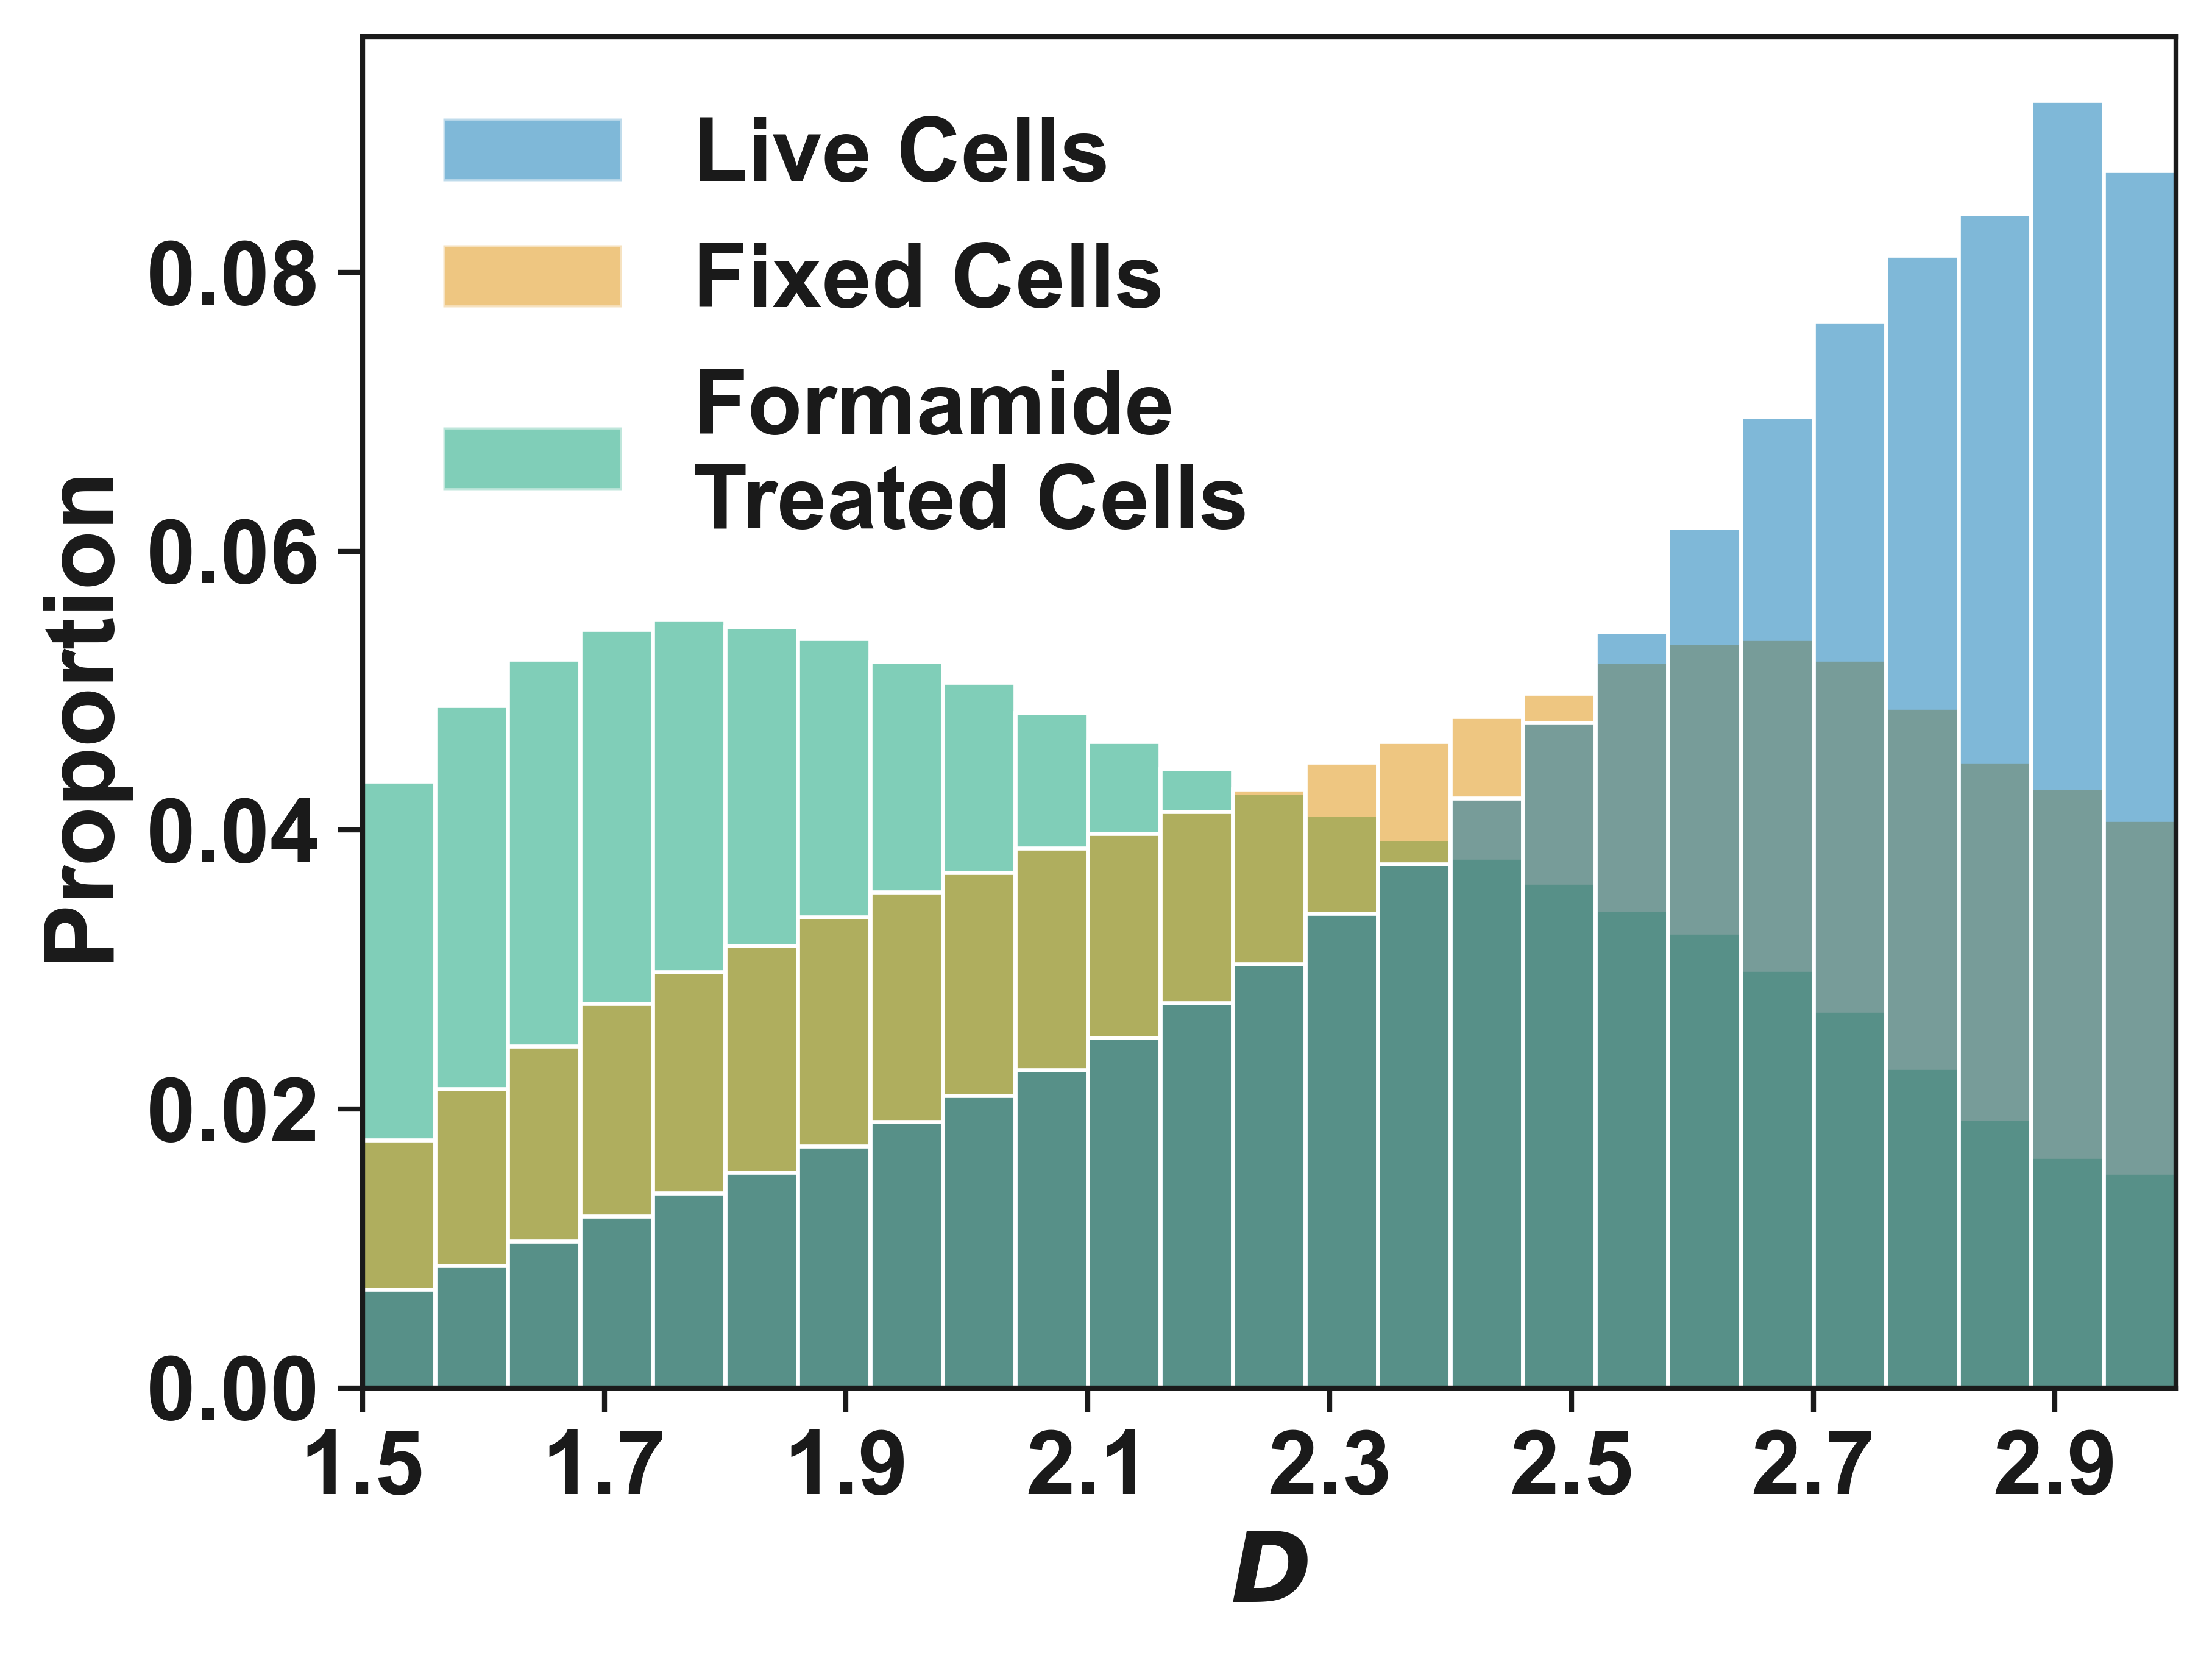

In [7]:
fishprot = all_hist[all_hist['Figure']==1].copy()
conds = ['Live Cells','Fixed Cells','Formamide Treated Cells']
fishprot['Condition'] = pd.Categorical(fishprot['Condition'],categories=conds)
fishprot.sort_values('Condition',ignore_index=True,inplace=True)

fig, ax = plt.subplots()
sns.histplot(data=fishprot,x='D',hue='Condition',stat='proportion',common_norm=False,binrange=[1.5,3.0],bins=25)
ax.set_xlabel(r'$D$')
ax.set_xlim([1.5,3.0])
ax.xaxis.set_ticks(np.arange(1.5, 3.0, 0.2))
l_h = [mpl.patches.Patch(facecolor=colorblindpal[0],edgecolor=None,alpha=0.5,label='Live Cells'),
       mpl.patches.Patch(facecolor=colorblindpal[1],edgecolor=None,alpha=0.5,label='Fixed Cells'),
       mpl.patches.Patch(facecolor=colorblindpal[2],edgecolor=None,alpha=0.5,label='Formamide\nTreated Cells')]
legend = plt.legend(handles=l_h,title='')

plotbarinfo = pd.DataFrame(columns=['Condition','D','Proportion'])
condnum = len(conds)
for num,p in enumerate(ax.patches):
    if p.get_x()==1.5:
        condnum -= 1
    plotbarinfo.loc[num,'Condition'] = conds[condnum]
    plotbarinfo.loc[num,'D'] = p.get_x()
    plotbarinfo.loc[num,'Proportion'] = p.get_height()

plt.show()
fig.savefig(save_dir+'\\FISH PWS Histogram.pdf',dpi=600,transparent=True,bbox_inches='tight')

In [8]:
fishhisttable_col = ['Condition','Mean','Median','Mode','STDev']
fishhisttable = pd.DataFrame(columns=fishhisttable_col)
fishhisttable['Condition'] = fishprot.Condition.unique()
fishhisttable['Mean'] = fishprot.groupby('Condition').describe()['D','mean'].values
fishhisttable['Median'] = fishprot.groupby('Condition').D.median().values
fishhisttable['Mode'] = [plotbarinfo.loc[np.argmax(plotbarinfo.loc[plotbarinfo.Condition==cond,'Proportion']),'D'] 
                         for cond in fishhisttable['Condition']]
fishhisttable['STDev'] = fishprot.groupby('Condition').describe()['D','std'].values

print(fishhisttable)
fishhisttable.to_csv(save_dir+'\\Stats for Comparison of FISH Protocol Histogram.csv',index=False)

                 Condition      Mean    Median  Mode     STDev
0               Live Cells  2.520149  2.625604  2.88  0.383721
1              Fixed Cells  2.309247  2.359877  2.64  0.428830
2  Formamide Treated Cells  2.059892  2.020076  1.74  0.431824


# FISH Protocol Optimization Before Formamide

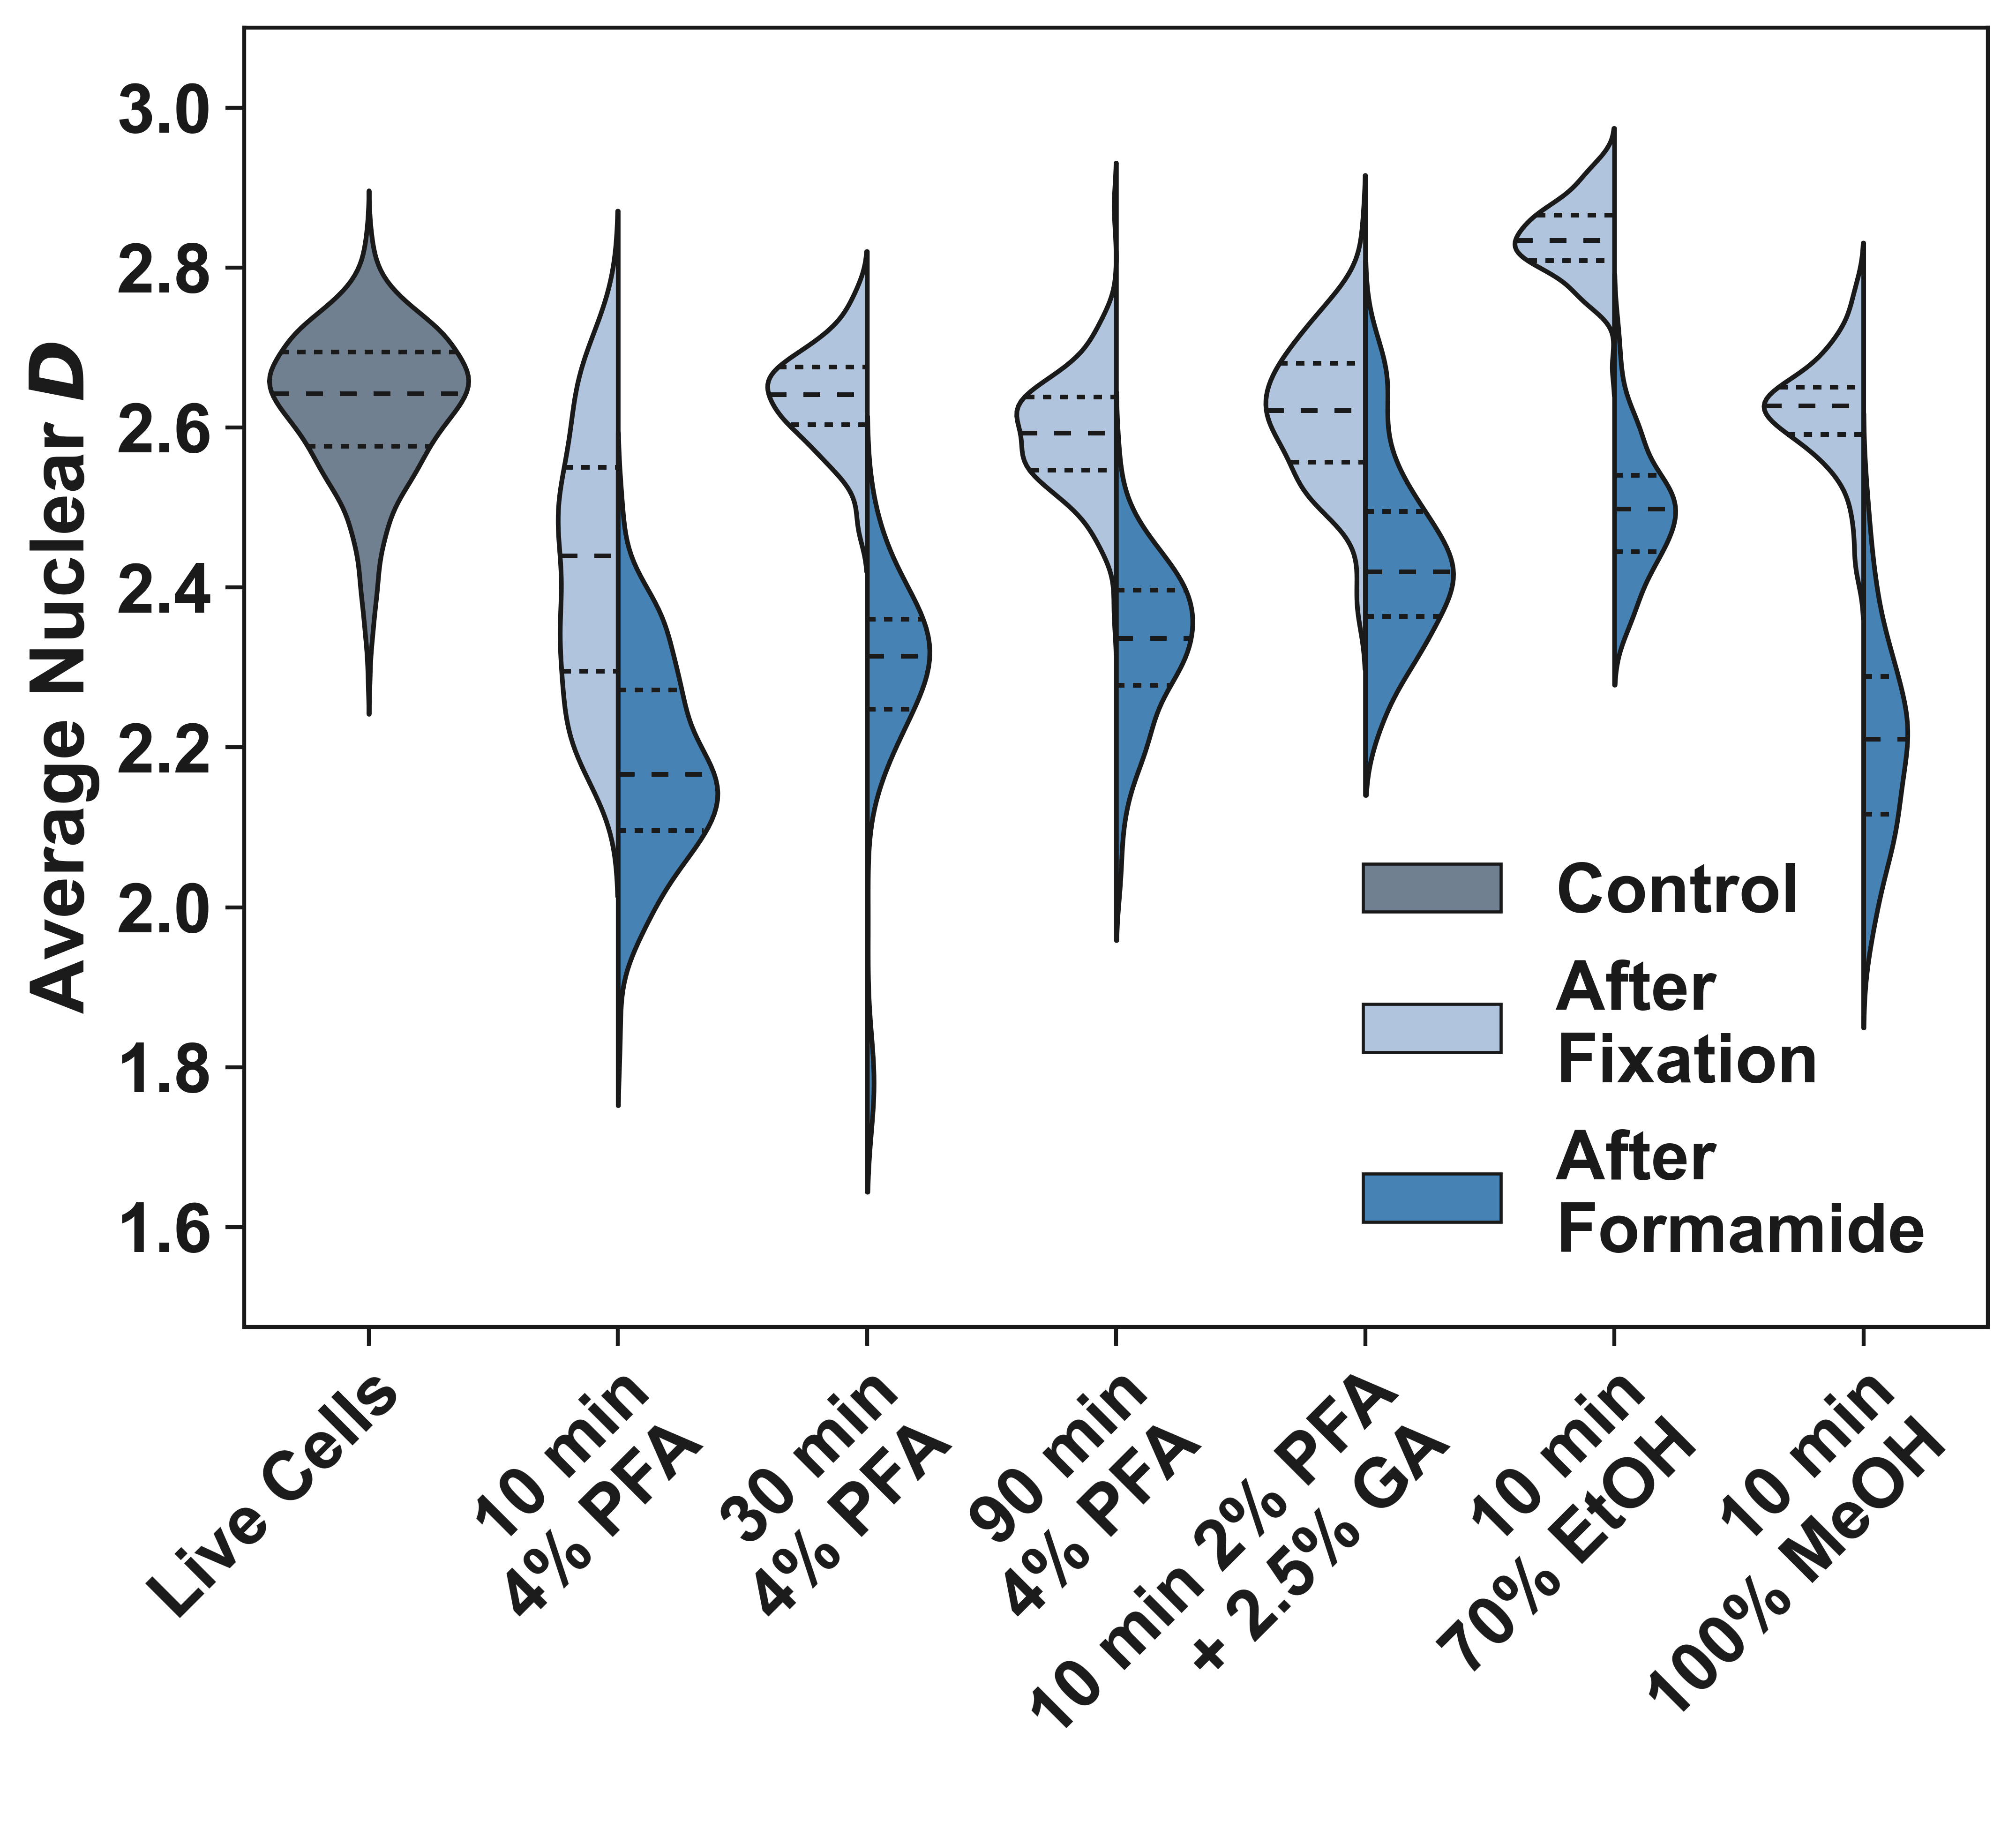

In [9]:
fix_fig = all_data[all_data.Experiment=='Fixation Optimization'].copy()
fix_fig['Fixative'] = 'Live'
fix_fig['Treatment'] = 'Live'
fix_split = fix_fig[fix_fig.Condition!='Live'].Condition.str.split(' After ')
fix_fig.loc[fix_fig.Condition!='Live','Fixative'] = fix_split.str[0]
fix_fig.loc[fix_fig.Condition!='Live','Treatment'] = fix_split.str[1]

fix_order = ['Live','10 min 4% PFA','30 min 4% PFA','90 min 4% PFA','10 min 2% PFA 2.5% GA','10 min 70% EtOH',
             '10 min 100% MeOH']
fix_fig['Fixative'] = pd.Categorical(fix_fig['Fixative'],fix_order)
fix_fig.sort_values('Fixative',ignore_index=True,inplace=True)
fix_labels = ['Live Cells','10 min\n4% PFA','30 min\n4% PFA','90 min\n4% PFA','10 min 2% PFA\n+ 2.5% GA',
              '10 min\n70% EtOH','10 min\n100% MeOH']
fix_pal = {'Fixation':'lightsteelblue','Formamide':'steelblue'}

split_plot = fix_fig.copy()
split_plot.loc[split_plot.Condition=='Live','D'] = np.nan
split_plot.loc[split_plot.Condition=='Live','Treatment'] = 'Fixation'

fig, ax = plt.subplots(figsize=[8,6])
sns.violinplot(data=fix_fig[fix_fig.Condition=='Live'],x='Fixative',y='D',inner='quart',saturation=1,ax=ax,
              order=fix_order,color=plot_pal['Live'])
sns.violinplot(data=split_plot,x='Fixative',y='D',hue='Treatment',split=True,inner='quart',saturation=1,
               ax=ax,palette=fix_pal,order=fix_order)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(fix_labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylim(D_plot_lim)
ax.set_xlabel('')
ax.set_ylabel(r'Average Nuclear $D$')
l_h = [mpl.patches.Patch(facecolor='slategray', edgecolor='k',label='Control'),
       mpl.patches.Patch(facecolor='lightsteelblue', edgecolor='k',label='After\nFixation'),
       mpl.patches.Patch(facecolor='steelblue', edgecolor='k',label='After\nFormamide')]
legend = plt.legend(handles=l_h,title='',loc='lower right')

plt.show()
fig.savefig(save_dir+'\\FISH Optimization before Formamide PWS.pdf',dpi=600,transparent=True,bbox_inches='tight')

In [10]:
fix_table = pd.DataFrame(columns=['Fixative','N Fix','N Form','Mean D Fix','Mean D Form','STD D Fix','STD D Form',
                                  'Delta D Fix','Delta D Form','Delta D Between','Percent Change Fix',
                                  'Percent Change Form','Percent Change Between','Pval Fix','Pval Corr Fix','Pval Form',
                                  'Pval Corr Form','Pval Between','Pval Corr Between'])
fix_table['Fixative'] = fix_fig.Fixative.unique()

fixed = fix_fig[fix_fig.Treatment=='Fixation'].copy()
fixed['Fixative'] = pd.Categorical(fixed['Fixative'],categories=fix_fig.Fixative.unique())
fixed.sort_values('Fixative',ignore_index=True,inplace=True)
form = fix_fig[fix_fig.Treatment=='Formamide'].copy()
form['Fixative'] = pd.Categorical(form['Fixative'],categories=fix_fig.Fixative.unique())
form.sort_values('Fixative',ignore_index=True,inplace=True)

fix_table['N Fix'] = fixed.groupby('Fixative').describe()['D','count'].values.astype(int)
fix_table['N Form'] = form.groupby('Fixative').describe()['D','count'].values.astype(int) 
fix_table['Mean D Fix'] = fixed.groupby('Fixative').describe()['D','mean'].values
fix_table['Mean D Form'] = form.groupby('Fixative').describe()['D','mean'].values
fix_table.loc[fix_table.Fixative=='Live',['N Fix','N Form']] = fix_fig.groupby('Fixative').D.count()['Live']
fix_table.loc[fix_table.Fixative=='Live',['Mean D Fix',
                                                 'Mean D Form']] = fix_fig.groupby('Fixative').D.mean()['Live']

live_ctrl = fix_table.loc[fix_table.Fixative=='Live','Mean D Fix'].item()
fix_table['STD D Fix'] = fixed.groupby('Fixative').describe()['D','std'].values
fix_table['STD D Form'] = form.groupby('Fixative').describe()['D','std'].values
fix_table.loc[fix_table.Fixative=='Live',['STD D Fix',
                                                 'STD D Form']] = fix_fig.groupby('Fixative').D.std()['Live']
fix_table['Delta D Fix'] = fix_table['Mean D Fix']-live_ctrl
fix_table['Delta D Form'] = fix_table['Mean D Form']-live_ctrl
fix_table['Delta D Between'] = fix_table['Mean D Form']-fix_table['Mean D Fix']
fix_table['Percent Change Fix'] = fix_table['Delta D Fix']/live_ctrl*100
fix_table['Percent Change Form'] = fix_table['Delta D Form']/live_ctrl*100
fix_table['Percent Change Between'] = fix_table['Delta D Between']/fix_table['Mean D Fix']*100

fix_comp = mc.MultiComparison(fix_fig['D'], fix_fig['Condition'])
tbl, a1, a2 = fix_comp.allpairtest(stats.ttest_ind, method= 'bonf')
fix_stats = pd.read_html(tbl.as_html(),header=0)[0]
fixed_stats = fix_stats[((fix_stats['group1']=='Live')|(fix_stats['group2']=='Live'))&
                        ((fix_stats['group1'].str.contains('Fixation'))|
                         (fix_stats['group2'].str.contains('Fixation')))].copy()
fixed_stats.loc[fix_stats['group1']!='Live',
                   ['group1','group2']] = fixed_stats.loc[fix_stats['group1']!='Live',['group2','group1']].values
fixed_stats['group2'] = pd.Categorical(fixed_stats['group2'],categories=fixed.Condition.unique())
fixed_stats.sort_values('group2',ignore_index=True,inplace=True)
form_stats = fix_stats[((fix_stats['group1']=='Live')|(fix_stats['group2']=='Live'))&
                        ((fix_stats['group1'].str.contains('Form'))|(fix_stats['group2'].str.contains('Form')))].copy()
form_stats.loc[fix_stats['group1']!='Live',
                   ['group1','group2']] = form_stats.loc[fix_stats['group1']!='Live',['group2','group1']].values
form_stats['group2'] = pd.Categorical(form_stats['group2'],categories=form.Condition.unique())
form_stats.sort_values('group2',ignore_index=True,inplace=True)

fix_table['Pval Fix'] = np.insert(pd.DataFrame(a1[0][fixed_stats.index])[1].values,0,math.nan)
fix_table['Pval Form'] = np.insert(pd.DataFrame(a1[0][form_stats.index])[1].values,0,math.nan)
fix_table['Pval Corr Fix'] = np.insert(a1[2][fixed_stats.index],0,math.nan)
fix_table['Pval Corr Form'] = np.insert(a1[2][form_stats.index],0,math.nan)

bet_ind = [fix_stats[(fix_stats['group1'].str.contains(cond))&(fix_stats['group2'].str.contains(cond))].index.item() 
           for cond in fix_fig.Fixative.unique() if cond!='Live']
fix_table['Pval Between'] = np.insert(pd.DataFrame(a1[0][bet_ind])[1].values,0,math.nan)
fix_table['Pval Corr Between'] = np.insert(a1[2][bet_ind],0,math.nan)
print(fix_table)
fix_table.to_csv(save_dir+'\\Stats for Fixation Optimization.csv',index=False)

                Fixative  N Fix  N Form  Mean D Fix  Mean D Form  STD D Fix  \
0                   Live   1039    1039    2.629434     2.629434   0.091634   
1          10 min 4% PFA    144     147    2.429038     2.181467   0.160595   
2          30 min 4% PFA    115     121    2.635658     2.278986   0.061919   
3          90 min 4% PFA    129     130    2.592053     2.328230   0.072004   
4  10 min 2% PFA 2.5% GA    131     143    2.618458     2.437534   0.089324   
5        10 min 70% EtOH    122     118    2.835808     2.499062   0.046731   
6       10 min 100% MeOH    113     147    2.618130     2.205890   0.068816   

   STD D Form  Delta D Fix  Delta D Form  Delta D Between  Percent Change Fix  \
0    0.091634     0.000000      0.000000         0.000000            0.000000   
1    0.121045    -0.200396     -0.447966        -0.247570           -7.621255   
2    0.153149     0.006224     -0.350448        -0.356672            0.236699   
3    0.099478    -0.037381     -0.301204   

In [11]:
print(tbl)

        Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.00, alphacBonf=0.001        
                group1                                group2                  stat    pval  pval_corr reject
------------------------------------------------------------------------------------------------------------
      10 min 100% MeOH After Fixation      10 min 100% MeOH After Formamide  31.9328    0.0       0.0   True
      10 min 100% MeOH After Fixation  10 min 2% PFA 2.5% GA After Fixation  -0.0318 0.9747       1.0  False
      10 min 100% MeOH After Fixation 10 min 2% PFA 2.5% GA After Formamide  14.8987    0.0       0.0   True
      10 min 100% MeOH After Fixation          10 min 4% PFA After Fixation  11.6982    0.0       0.0   True
      10 min 100% MeOH After Fixation         10 min 4% PFA After Formamide  34.3119    0.0       0.0   True
      10 min 100% MeOH After Fixation        10 min 70% EtOH After Fixation -28.5493    0.0       0.0   True
      10 min 100% M

# FISH Protocol Optimization After Formamide

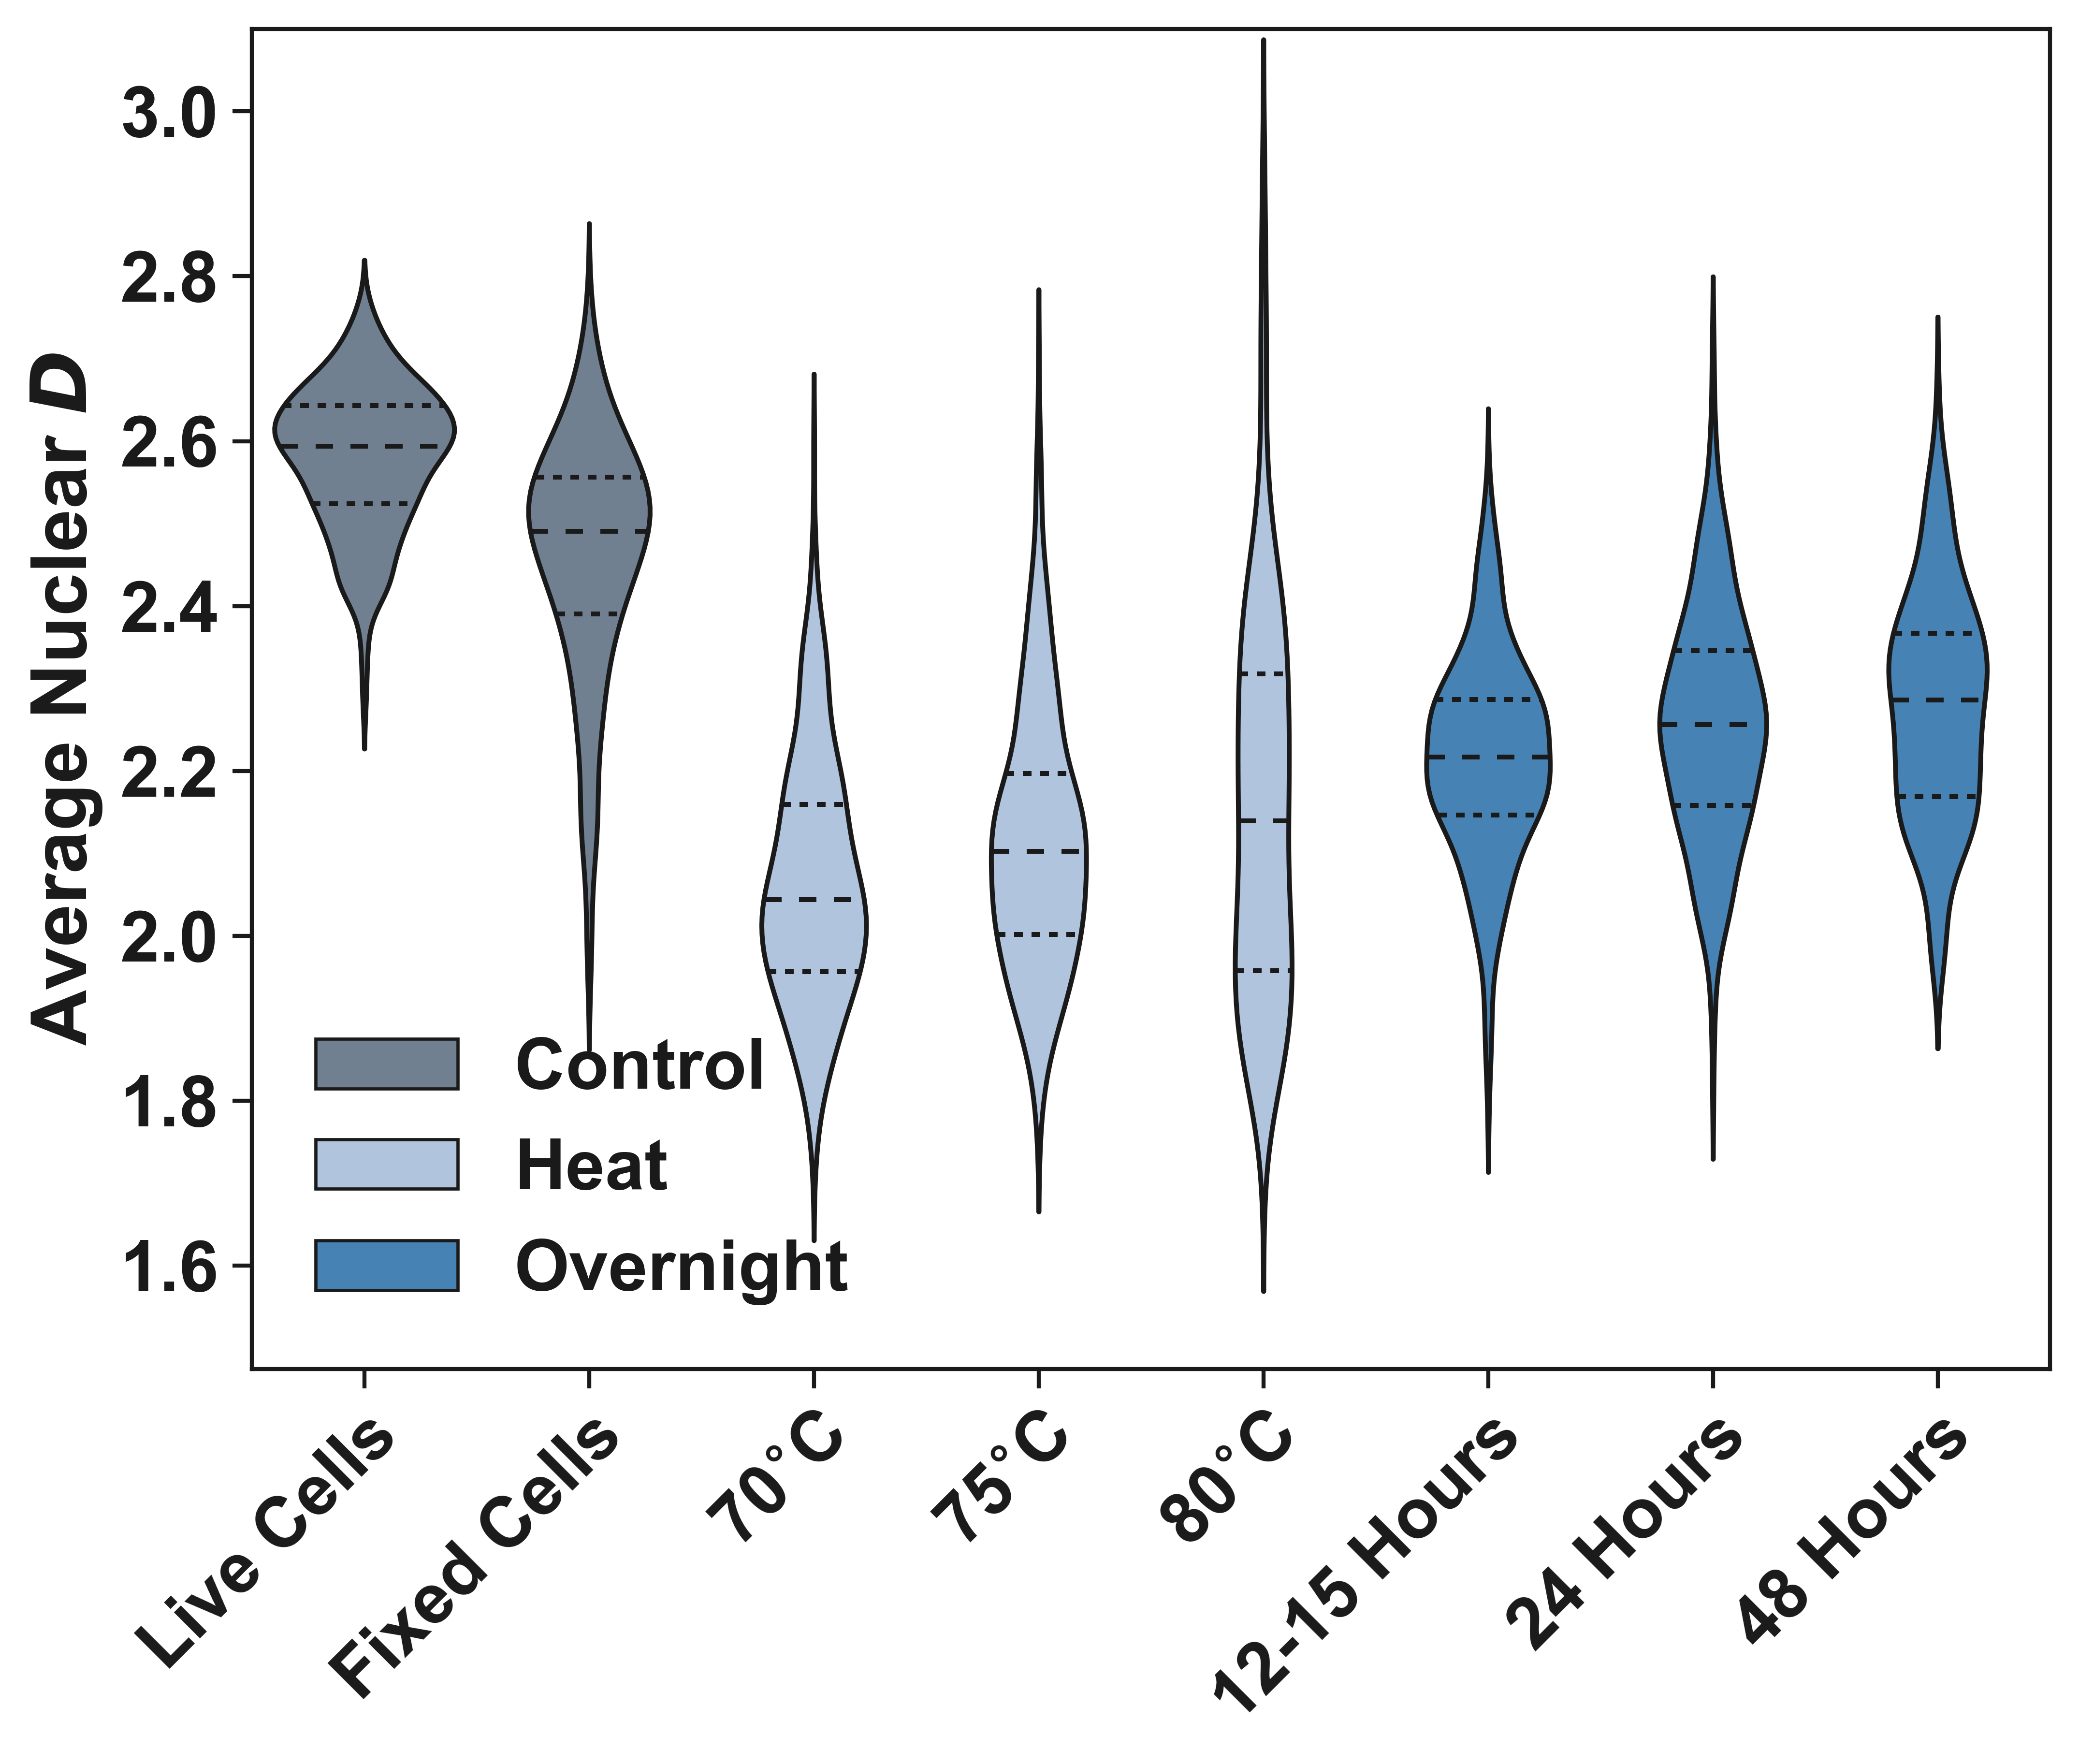

In [12]:
optim_fig = all_data[all_data.Experiment=='Optimization After Formamide'].copy()
optim_order = ['Live','PFA','70C','75C','80C','12-15 Hours','24 Hours','48 Hours']
optim_fig = optim_fig[optim_fig.Condition.isin(optim_order)]
optim_fig['Condition'] = pd.Categorical(optim_fig['Condition'],optim_order)
optim_fig.sort_values('Condition',ignore_index=True,inplace=True)
optim_pal = {sample:'lightsteelblue' if 'C' in sample else 'steelblue' if 'Hour' in sample else 'slategrey' 
             for sample in optim_fig.Condition.unique()}
optim_lab = ['Live Cells','Fixed Cells','70$\!^\circ\!$C','75$\!^\circ\!$C','80$\!^\circ\!$C','12-15 Hours','24 Hours',
             '48 Hours']

fig, ax = plt.subplots(figsize=[8,6])
sns.violinplot(data=optim_fig,x='Condition',y='D',order=optim_order,palette=optim_pal,saturation=1,inner='quart')
ax.set_xticklabels(optim_lab, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylim(D_plot_lim)
ax.set_xlabel('')
ax.set_ylabel(r'Average Nuclear $D$')
l_h = [mpl.patches.Patch(facecolor='slategrey', edgecolor='k',label='Control'),
       mpl.patches.Patch(facecolor='lightsteelblue', edgecolor='k',label='Heat'),
       mpl.patches.Patch(facecolor='steelblue', edgecolor='k',label='Overnight')]
legend = plt.legend(handles=l_h,title='',loc='lower left')

plt.show()
fig.savefig(save_dir+'\\FISH Optimization after Formamide PWS.pdf',dpi=600,transparent=True,bbox_inches='tight')

In [13]:
optim_table = pd.DataFrame(columns=['Condition','N','Mean D','STD D','Live Delta D','Live % Change','Fixed Delta D',
                                   'Fixed % Change','Live Pval','Live Pval Corr','Fixed Pval','Fixed Pval Corr'])
optim_table['Condition'] = optim_fig.Condition.unique()
optim_table['N'] = optim_fig.groupby('Condition').describe()['D','count'].values.astype(int)
optim_table['Mean D'] = optim_fig.groupby('Condition').describe()['D','mean'].values
optim_table['STD D'] = optim_fig.groupby('Condition').describe()['D','std'].values

optim_ctrl = optim_table.loc[optim_table.Condition=='Live','Mean D'].item()
optim_table['Live Delta D'] = optim_table['Mean D']-optim_ctrl
optim_table['Live % Change'] = optim_table['Live Delta D']/optim_ctrl*100

optim_fix = optim_table.loc[optim_table.Condition=='PFA','Mean D'].item()
optim_table['Fixed Delta D'] = optim_table['Mean D']-optim_fix
optim_table['Fixed % Change'] = optim_table['Fixed Delta D']/optim_fix*100

optim_optim = mc.MultiComparison(optim_fig['D'], optim_fig['Condition'])
tbl, a1, a2 = optim_optim.allpairtest(stats.ttest_ind, method= 'bonf')
optim_stats = pd.read_html(tbl.as_html(),header=0)[0]

optim_fig_stats = optim_stats[(optim_stats['group1']=='Live')|(optim_stats['group2']=='Live')].copy()
optim_fig_stats.loc[optim_stats['group1']!='Live',
                   ['group1','group2']] = optim_fig_stats.loc[optim_stats['group1']!='Live',['group2','group1']].values
optim_fig_stats['group2'] = pd.Categorical(optim_fig_stats['group2'],categories=optim_fig.Condition.unique())
optim_fig_stats.sort_values('group2',ignore_index=True,inplace=True)
optim_table['Live Pval'] = np.insert(pd.DataFrame(a1[0][optim_fig_stats.index])[1].values,0,math.nan)
optim_table['Live Pval Corr'] = np.insert(a1[2][optim_fig_stats.index],0,math.nan)

optim_fig_stats = optim_stats[(optim_stats['group1']=='PFA')|(optim_stats['group2']=='PFA')].copy()
optim_fig_stats.loc[optim_stats['group1']!='PFA',
                   ['group1','group2']] = optim_fig_stats.loc[optim_stats['group1']!='PFA',['group2','group1']].values
optim_fig_stats['group2'] = pd.Categorical(optim_fig_stats['group2'],categories=optim_fig.Condition.unique())
optim_fig_stats.sort_values('group2',ignore_index=True,inplace=True)
optim_table['Fixed Pval'] = np.insert(pd.DataFrame(a1[0][optim_fig_stats.index])[1].values,1,math.nan)
optim_table['Fixed Pval Corr'] = np.insert(a1[2][optim_fig_stats.index],1,math.nan)

print(optim_table)
optim_table.to_csv(save_dir+'\\Stats for Optimization After Formamide.csv',index=False)

     Condition    N    Mean D     STD D  Live Delta D  Live % Change  \
0         Live  427  2.580361  0.087708      0.000000       0.000000   
1          PFA  419  2.460097  0.148458     -0.120265      -4.660765   
2          70C  425  2.062873  0.147293     -0.517488     -20.054862   
3          75C  395  2.113332  0.157513     -0.467029     -18.099380   
4          80C  396  2.157834  0.237023     -0.422528     -16.374745   
5  12-15 Hours  430  2.214271  0.124883     -0.366090     -14.187554   
6     24 Hours  332  2.255207  0.140806     -0.325154     -12.601107   
7     48 Hours  216  2.277554  0.138067     -0.302807     -11.735067   

   Fixed Delta D  Fixed % Change      Live Pval  Live Pval Corr  \
0       0.120265        4.888611            NaN             NaN   
1       0.000000        0.000000   4.390130e-42    1.229236e-40   
2      -0.397223      -16.146655  2.657184e-319   7.440115e-318   
3      -0.346765      -14.095577  3.311947e-267   9.273452e-266   
4      -0.302263

In [14]:
print(tbl)

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.00, alphacBonf=0.002
   group1    group2    stat    pval  pval_corr reject
-----------------------------------------------------
12-15 Hours 24 Hours  -4.2431    0.0    0.0007   True
12-15 Hours 48 Hours  -5.8625    0.0       0.0   True
12-15 Hours      70C  16.2176    0.0       0.0   True
12-15 Hours      75C  10.2393    0.0       0.0   True
12-15 Hours      80C   4.3282    0.0    0.0005   True
12-15 Hours     Live -49.6285    0.0       0.0   True
12-15 Hours      PFA -26.1344    0.0       0.0   True
   24 Hours 48 Hours  -1.8295 0.0679       1.0  False
   24 Hours      70C   18.174    0.0       0.0   True
   24 Hours      75C  12.6934    0.0       0.0   True
   24 Hours      80C   6.5753    0.0       0.0   True
   24 Hours     Live -38.9773    0.0       0.0   True
   24 Hours      PFA -19.2145    0.0       0.0   True
   48 Hours      70C  17.8097    0.0       0.0   True
   48 Hours      75C  12.8573    0.0       

# Comparison of PWS Data Across Techniques

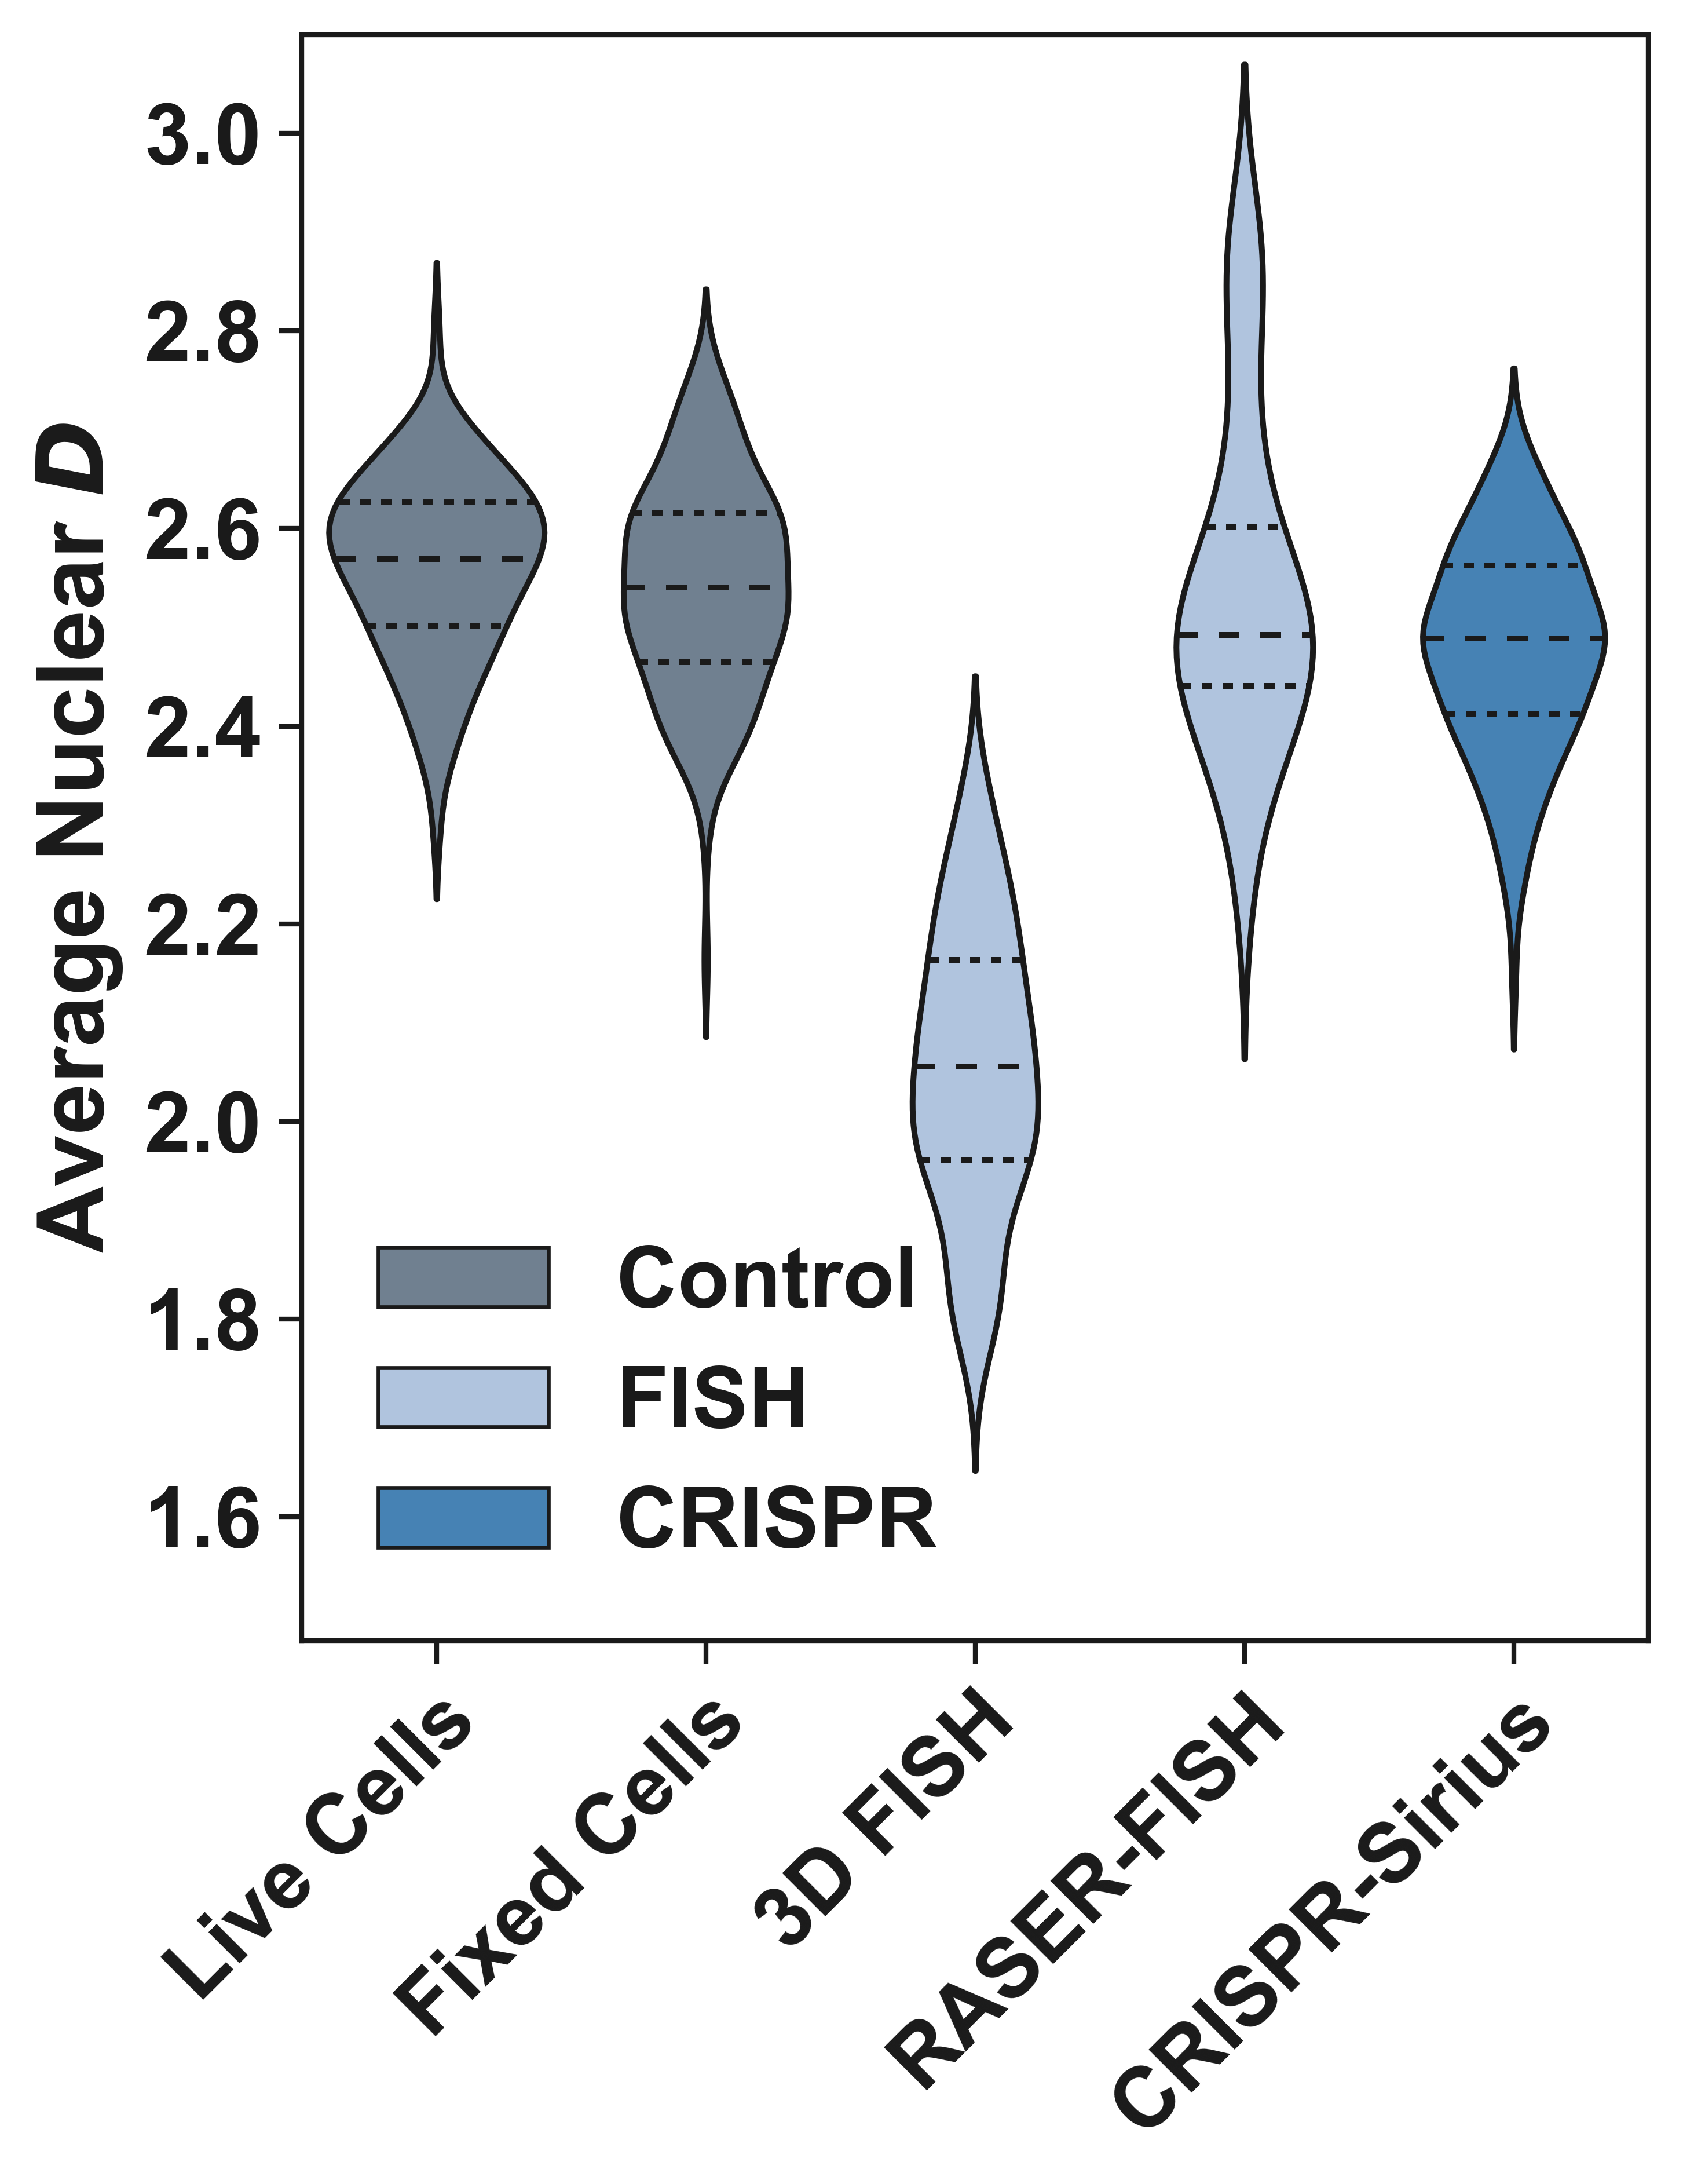

In [15]:
comp_fig = all_data[all_data.Experiment=='Protocol Comparison'].copy()
comp_fig['Sample'] = comp_fig['Labeling Protocol']
comp_fig.loc[comp_fig.Sample=='No Protocol','Sample'] = comp_fig.loc[comp_fig.Sample=='No Protocol','Condition']
comp_fig_order = ['Live','PFA','3D FISH','RASER-FISH','CRISPR-Sirius']
comp_fig['Sample'] = pd.Categorical(comp_fig['Sample'],comp_fig_order)
comp_fig.sort_values('Sample',ignore_index=True,inplace=True)

comp_pal = {sample:'lightsteelblue' if 'FISH' in sample else 'steelblue' if 'CRISPR' in sample else 'slategrey' 
             for sample in comp_fig.Sample.unique()}
comp_fig_labels = ['Live Cells','Fixed Cells','3D FISH','RASER-FISH','CRISPR-Sirius']

fig, ax = plt.subplots(figsize=[5,6])
sns.violinplot(data=comp_fig,x='Sample',y='D',saturation=1,inner='quart',palette=comp_pal)
ax.set_xticklabels(labels=comp_fig_labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylim(D_plot_lim)
ax.set_xlabel('')
ax.set_ylabel(r'Average Nuclear $D$')

l_h = [mpl.patches.Patch(facecolor='slategrey', edgecolor='k',label='Control'),
       mpl.patches.Patch(facecolor='lightsteelblue', edgecolor='k',label='FISH'),
       mpl.patches.Patch(facecolor='steelblue', edgecolor='k',label='CRISPR')]
legend = plt.legend(handles=l_h,title='',loc='lower left')

plt.show()
fig.savefig(save_dir+'\\Comparison PWS.pdf',dpi=600,transparent=True,bbox_inches='tight')

In [16]:
comp_table = pd.DataFrame(columns=['Sample','N','Mean D','STD D','Live Delta D','Live % Change','Fixed Delta D',
                                   'Fixed % Change','Live Pval','Live Pval Corr','Fixed Pval','Fixed Pval Corr'])
comp_table['Sample'] = comp_fig.Sample.unique()
comp_table['N'] = comp_fig.groupby('Sample').describe()['D','count'].values.astype(int)
comp_table['Mean D'] = comp_fig.groupby('Sample').describe()['D','mean'].values
comp_table['STD D'] = comp_fig.groupby('Sample').describe()['D','std'].values

comp_ctrl = comp_table.loc[comp_table.Sample=='Live','Mean D'].item()
comp_table['Live Delta D'] = comp_table['Mean D']-comp_ctrl
comp_table['Live % Change'] = comp_table['Live Delta D']/comp_ctrl*100

comp_fix = comp_table.loc[comp_table.Sample=='PFA','Mean D'].item()
comp_table['Fixed Delta D'] = comp_table['Mean D']-comp_fix
comp_table['Fixed % Change'] = comp_table['Fixed Delta D']/comp_fix*100

comp_comp = mc.MultiComparison(comp_fig['D'], comp_fig['Sample'])
tbl, a1, a2 = comp_comp.allpairtest(stats.ttest_ind, method= 'bonf')
comp_stats = pd.read_html(tbl.as_html(),header=0)[0]

comp_fig_stats = comp_stats[(comp_stats['group1']=='Live')|(comp_stats['group2']=='Live')].copy()
comp_fig_stats.loc[comp_stats['group1']!='Live',
                   ['group1','group2']] = comp_fig_stats.loc[comp_stats['group1']!='Live',['group2','group1']].values
comp_fig_stats['group2'] = pd.Categorical(comp_fig_stats['group2'],categories=comp_fig.Sample.unique())
comp_fig_stats.sort_values('group2',ignore_index=True,inplace=True)
comp_table['Live Pval'] = np.insert(pd.DataFrame(a1[0][comp_fig_stats.index])[1].values,0,math.nan)
comp_table['Live Pval Corr'] = np.insert(a1[2][comp_fig_stats.index],0,math.nan)

comp_fig_stats = comp_stats[(comp_stats['group1']=='PFA')|(comp_stats['group2']=='PFA')].copy()
comp_fig_stats.loc[comp_stats['group1']!='PFA',
                   ['group1','group2']] = comp_fig_stats.loc[comp_stats['group1']!='PFA',['group2','group1']].values
comp_fig_stats['group2'] = pd.Categorical(comp_fig_stats['group2'],categories=comp_fig.Sample.unique())
comp_fig_stats.sort_values('group2',ignore_index=True,inplace=True)
comp_table['Fixed Pval'] = np.insert(pd.DataFrame(a1[0][comp_fig_stats.index])[1].values,1,math.nan)
comp_table['Fixed Pval Corr'] = np.insert(a1[2][comp_fig_stats.index],1,math.nan)

print(comp_table)
comp_table.to_csv(save_dir+'\\Stats for Labeling Protocol Comparison.csv',index=False)

          Sample    N    Mean D     STD D  Live Delta D  Live % Change  \
0           Live  104  2.562309  0.090774      0.000000       0.000000   
1            PFA  154  2.541958  0.106513     -0.020351      -0.794226   
2        3D FISH  168  2.053326  0.143665     -0.508983     -19.864222   
3     RASER-FISH   74  2.536997  0.170107     -0.025312      -0.987840   
4  CRISPR-Sirius  148  2.477682  0.104713     -0.084626      -3.302727   

   Fixed Delta D  Fixed % Change     Live Pval  Live Pval Corr     Fixed Pval  \
0       0.020351        0.800584           NaN             NaN   1.117711e-01   
1       0.000000        0.000000  1.117711e-01    1.000000e+00            NaN   
2      -0.488632      -19.222667  7.420583e-95    7.420583e-94  1.385043e-109   
3      -0.004961       -0.195164  2.011308e-01    1.000000e+00   7.883403e-01   
4      -0.064276       -2.528584  1.663513e-10    1.663513e-09   2.411089e-07   

   Fixed Pval Corr  
0     1.000000e+00  
1              NaN  
2    

In [17]:
print(tbl)

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.005
    group1        group2      stat    pval  pval_corr reject
------------------------------------------------------------
      3D FISH CRISPR-Sirius -29.6566    0.0       0.0   True
      3D FISH          Live -32.3417    0.0       0.0   True
      3D FISH           PFA -34.4167    0.0       0.0   True
      3D FISH    RASER-FISH -22.7779    0.0       0.0   True
CRISPR-Sirius          Live  -6.6667    0.0       0.0   True
CRISPR-Sirius           PFA   -5.286    0.0       0.0   True
CRISPR-Sirius    RASER-FISH  -3.2021 0.0016    0.0157   True
         Live           PFA   1.5958 0.1118       1.0  False
         Live    RASER-FISH   1.2831 0.2011       1.0  False
          PFA    RASER-FISH   0.2688 0.7883       1.0  False
------------------------------------------------------------


# Histogram Analysis of All Techniques

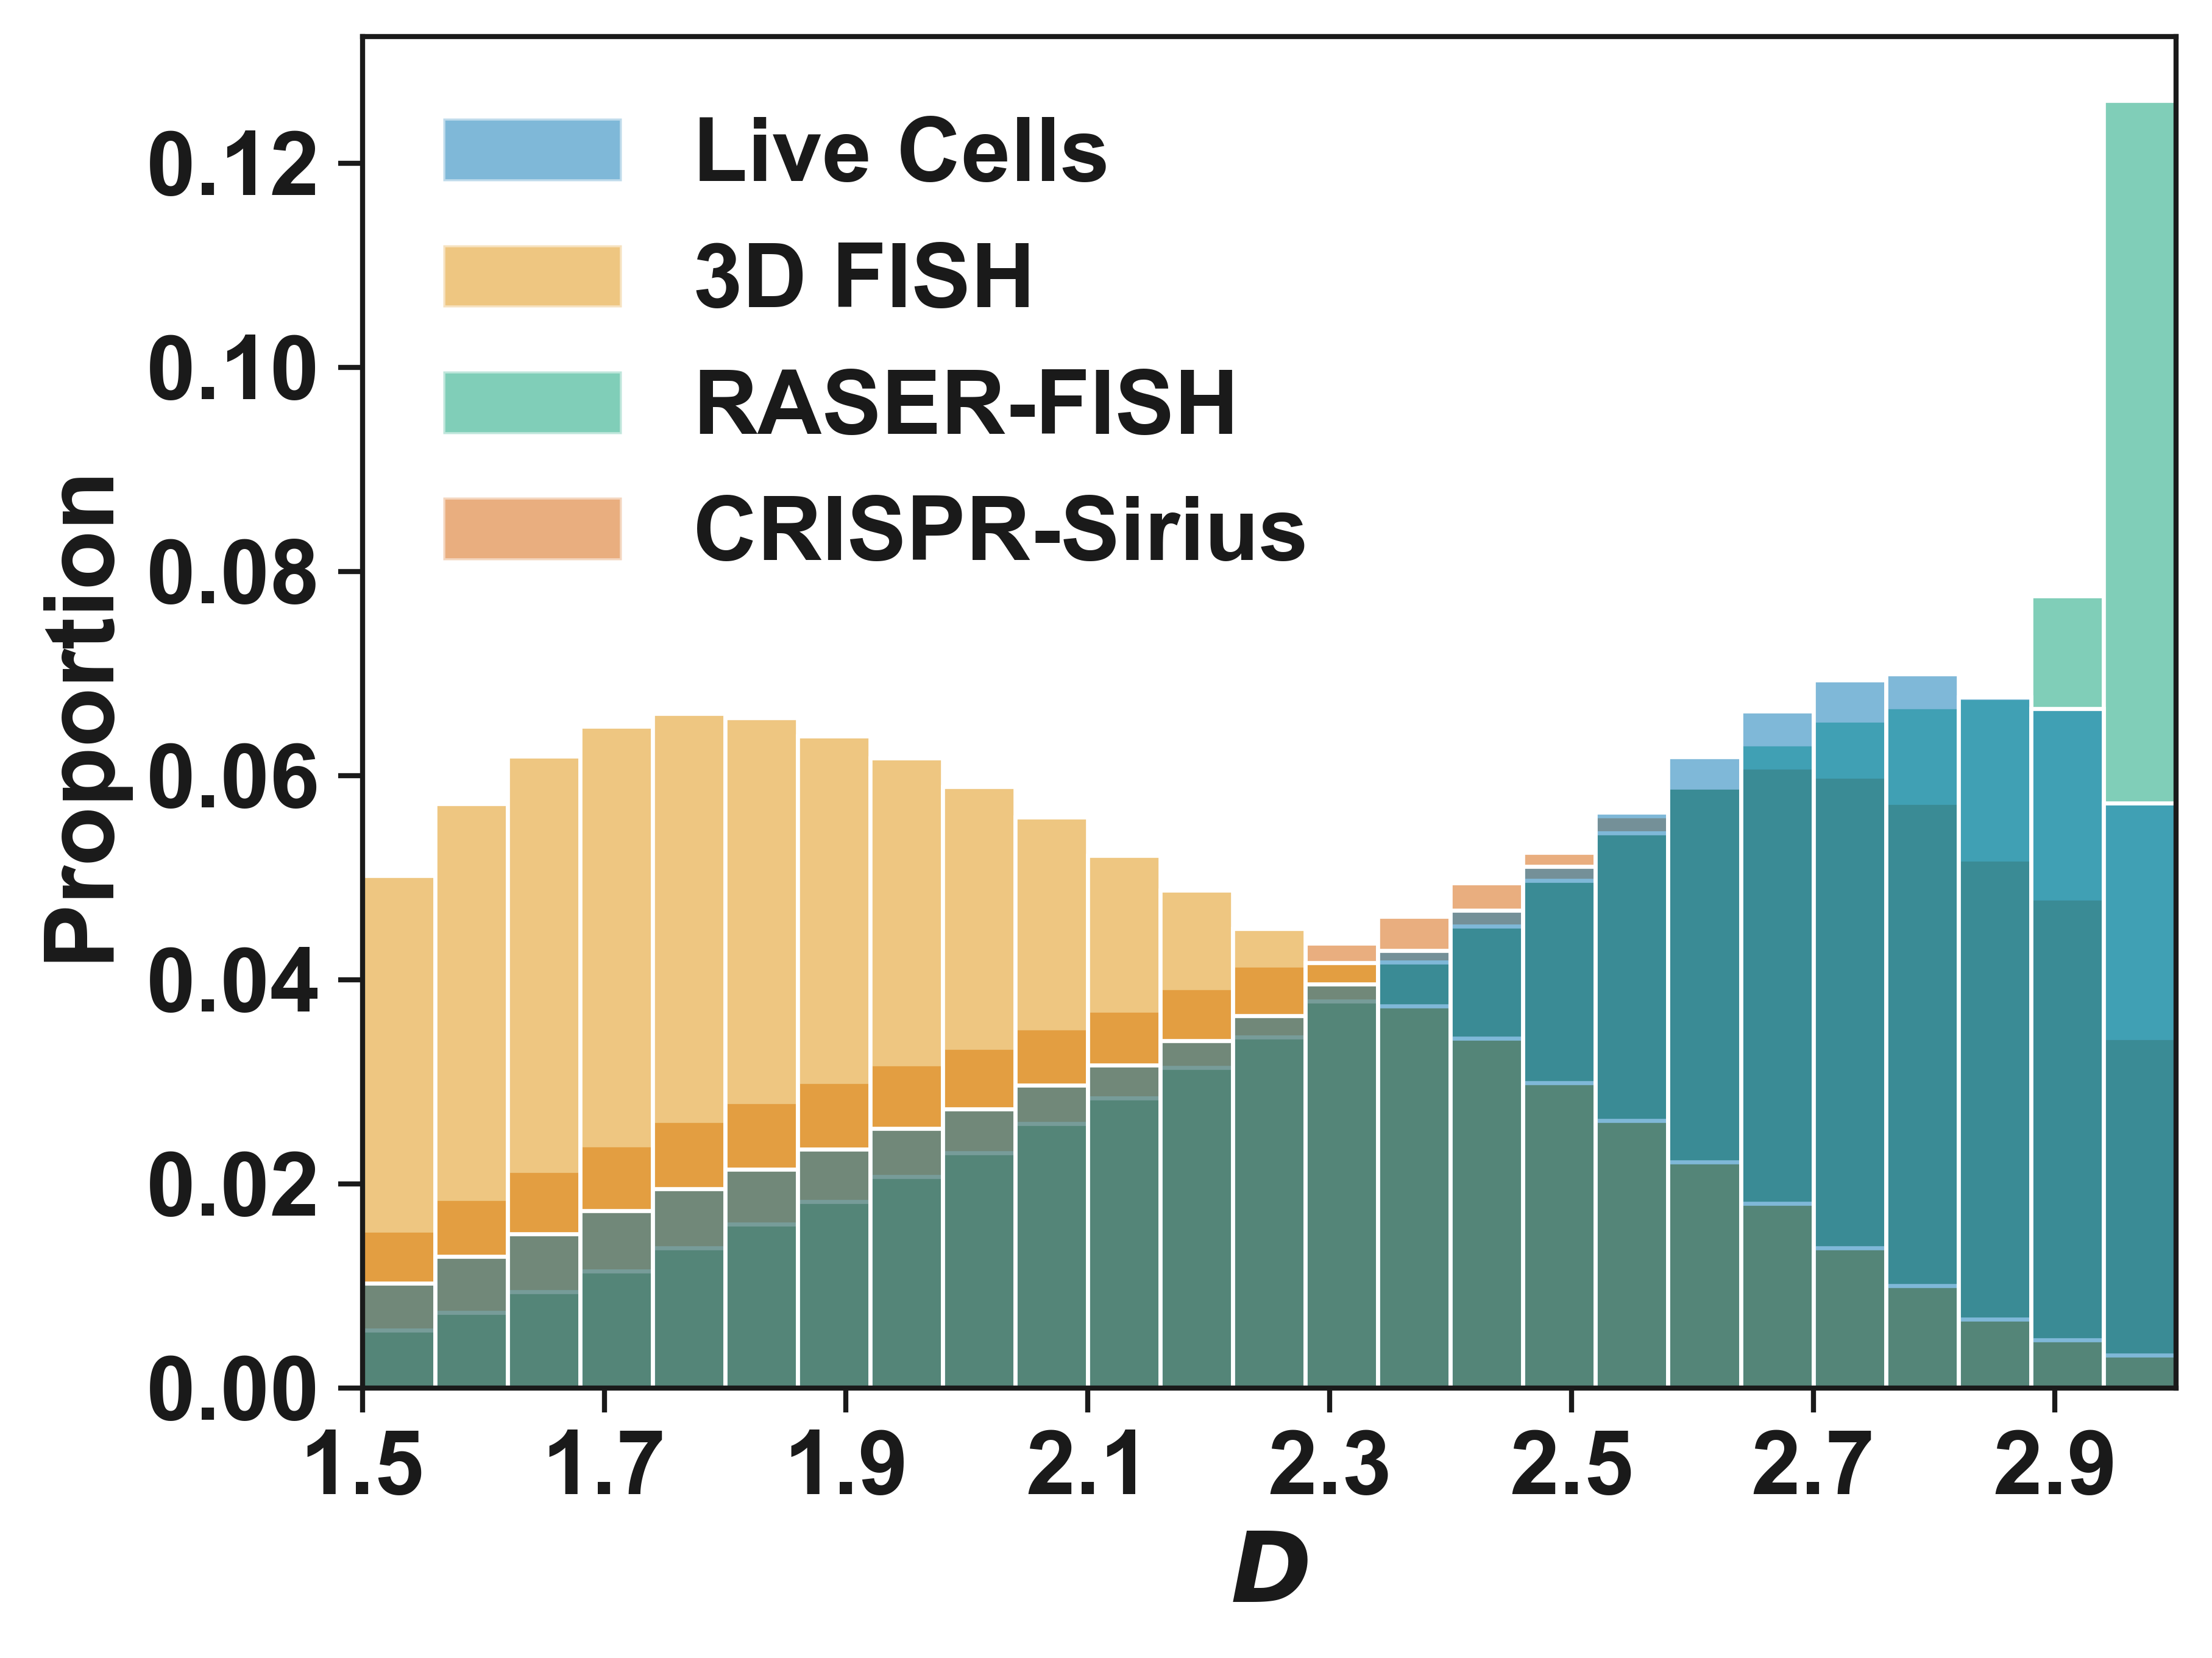

In [18]:
compprot = all_hist[all_hist['Figure']==3].copy()
conds = ['Live Cells','3D FISH','RASER-FISH','CRISPR-Sirius']
compprot['Condition'] = pd.Categorical(compprot['Condition'],categories=conds)
compprot.sort_values('Condition',ignore_index=True,inplace=True)

fig, ax = plt.subplots()
sns.histplot(data=compprot,x='D',hue='Condition',stat='proportion',common_norm=False,binrange=[1.5,3.0],bins=25,hue_order=conds)
ax.set_xlabel(r'$D$')
ax.set_xlim([1.5,3.0])
ax.xaxis.set_ticks(np.arange(1.5, 3.0, 0.2))
l_h = [mpl.patches.Patch(facecolor=colorblindpal[0],edgecolor=None,alpha=0.5,label='Live Cells'),
       mpl.patches.Patch(facecolor=colorblindpal[1],edgecolor=None,alpha=0.5,label='3D FISH'),
       mpl.patches.Patch(facecolor=colorblindpal[2],edgecolor=None,alpha=0.5,label='RASER-FISH'),
       mpl.patches.Patch(facecolor=colorblindpal[3],edgecolor=None,alpha=0.5,label='CRISPR-Sirius')]
legend = plt.legend(handles=l_h,title='')

plotbarinfo = pd.DataFrame(columns=['Condition','D','Proportion'])
condnum = len(conds)
for num,p in enumerate(ax.patches):
    if p.get_x()==1.5:
        condnum -= 1
    plotbarinfo.loc[num,'Condition'] = conds[condnum]
    plotbarinfo.loc[num,'D'] = p.get_x()
    plotbarinfo.loc[num,'Proportion'] = p.get_height()

plt.show()
fig.savefig(save_dir+'\\Comparison PWS Histogram.pdf',dpi=600,transparent=True,bbox_inches='tight')

In [19]:
comphisttable_col = ['Condition','Mean','Median','Mode','STDev']
comphisttable = pd.DataFrame(columns=comphisttable_col)
comphisttable['Condition'] = compprot.Condition.unique()
comphisttable['Mean'] = compprot.groupby('Condition').describe()['D','mean'].values
comphisttable['Median'] = compprot.groupby('Condition').D.median().values
comphisttable['Mode'] = [plotbarinfo.loc[np.argmax(plotbarinfo.loc[plotbarinfo.Condition==cond,'Proportion']),'D'] 
                         for cond in comphisttable['Condition']]
comphisttable['STDev'] = compprot.groupby('Condition').describe()['D','std'].values

print(comphisttable)
comphisttable.to_csv(save_dir+'\\Stats for Comparison of Labeling Protocols Histogram.csv',index=False)

       Condition      Mean    Median  Mode     STDev
0     Live Cells  2.435322  2.526267  2.76  0.403765
1        3D FISH  1.969536  1.933108  1.74  0.377716
2     RASER-FISH  2.518685  2.601767  2.94  0.380106
3  CRISPR-Sirius  2.345569  2.416435  2.64  0.420054


# CRISPR-Sirius sgRNAs and Aptamers

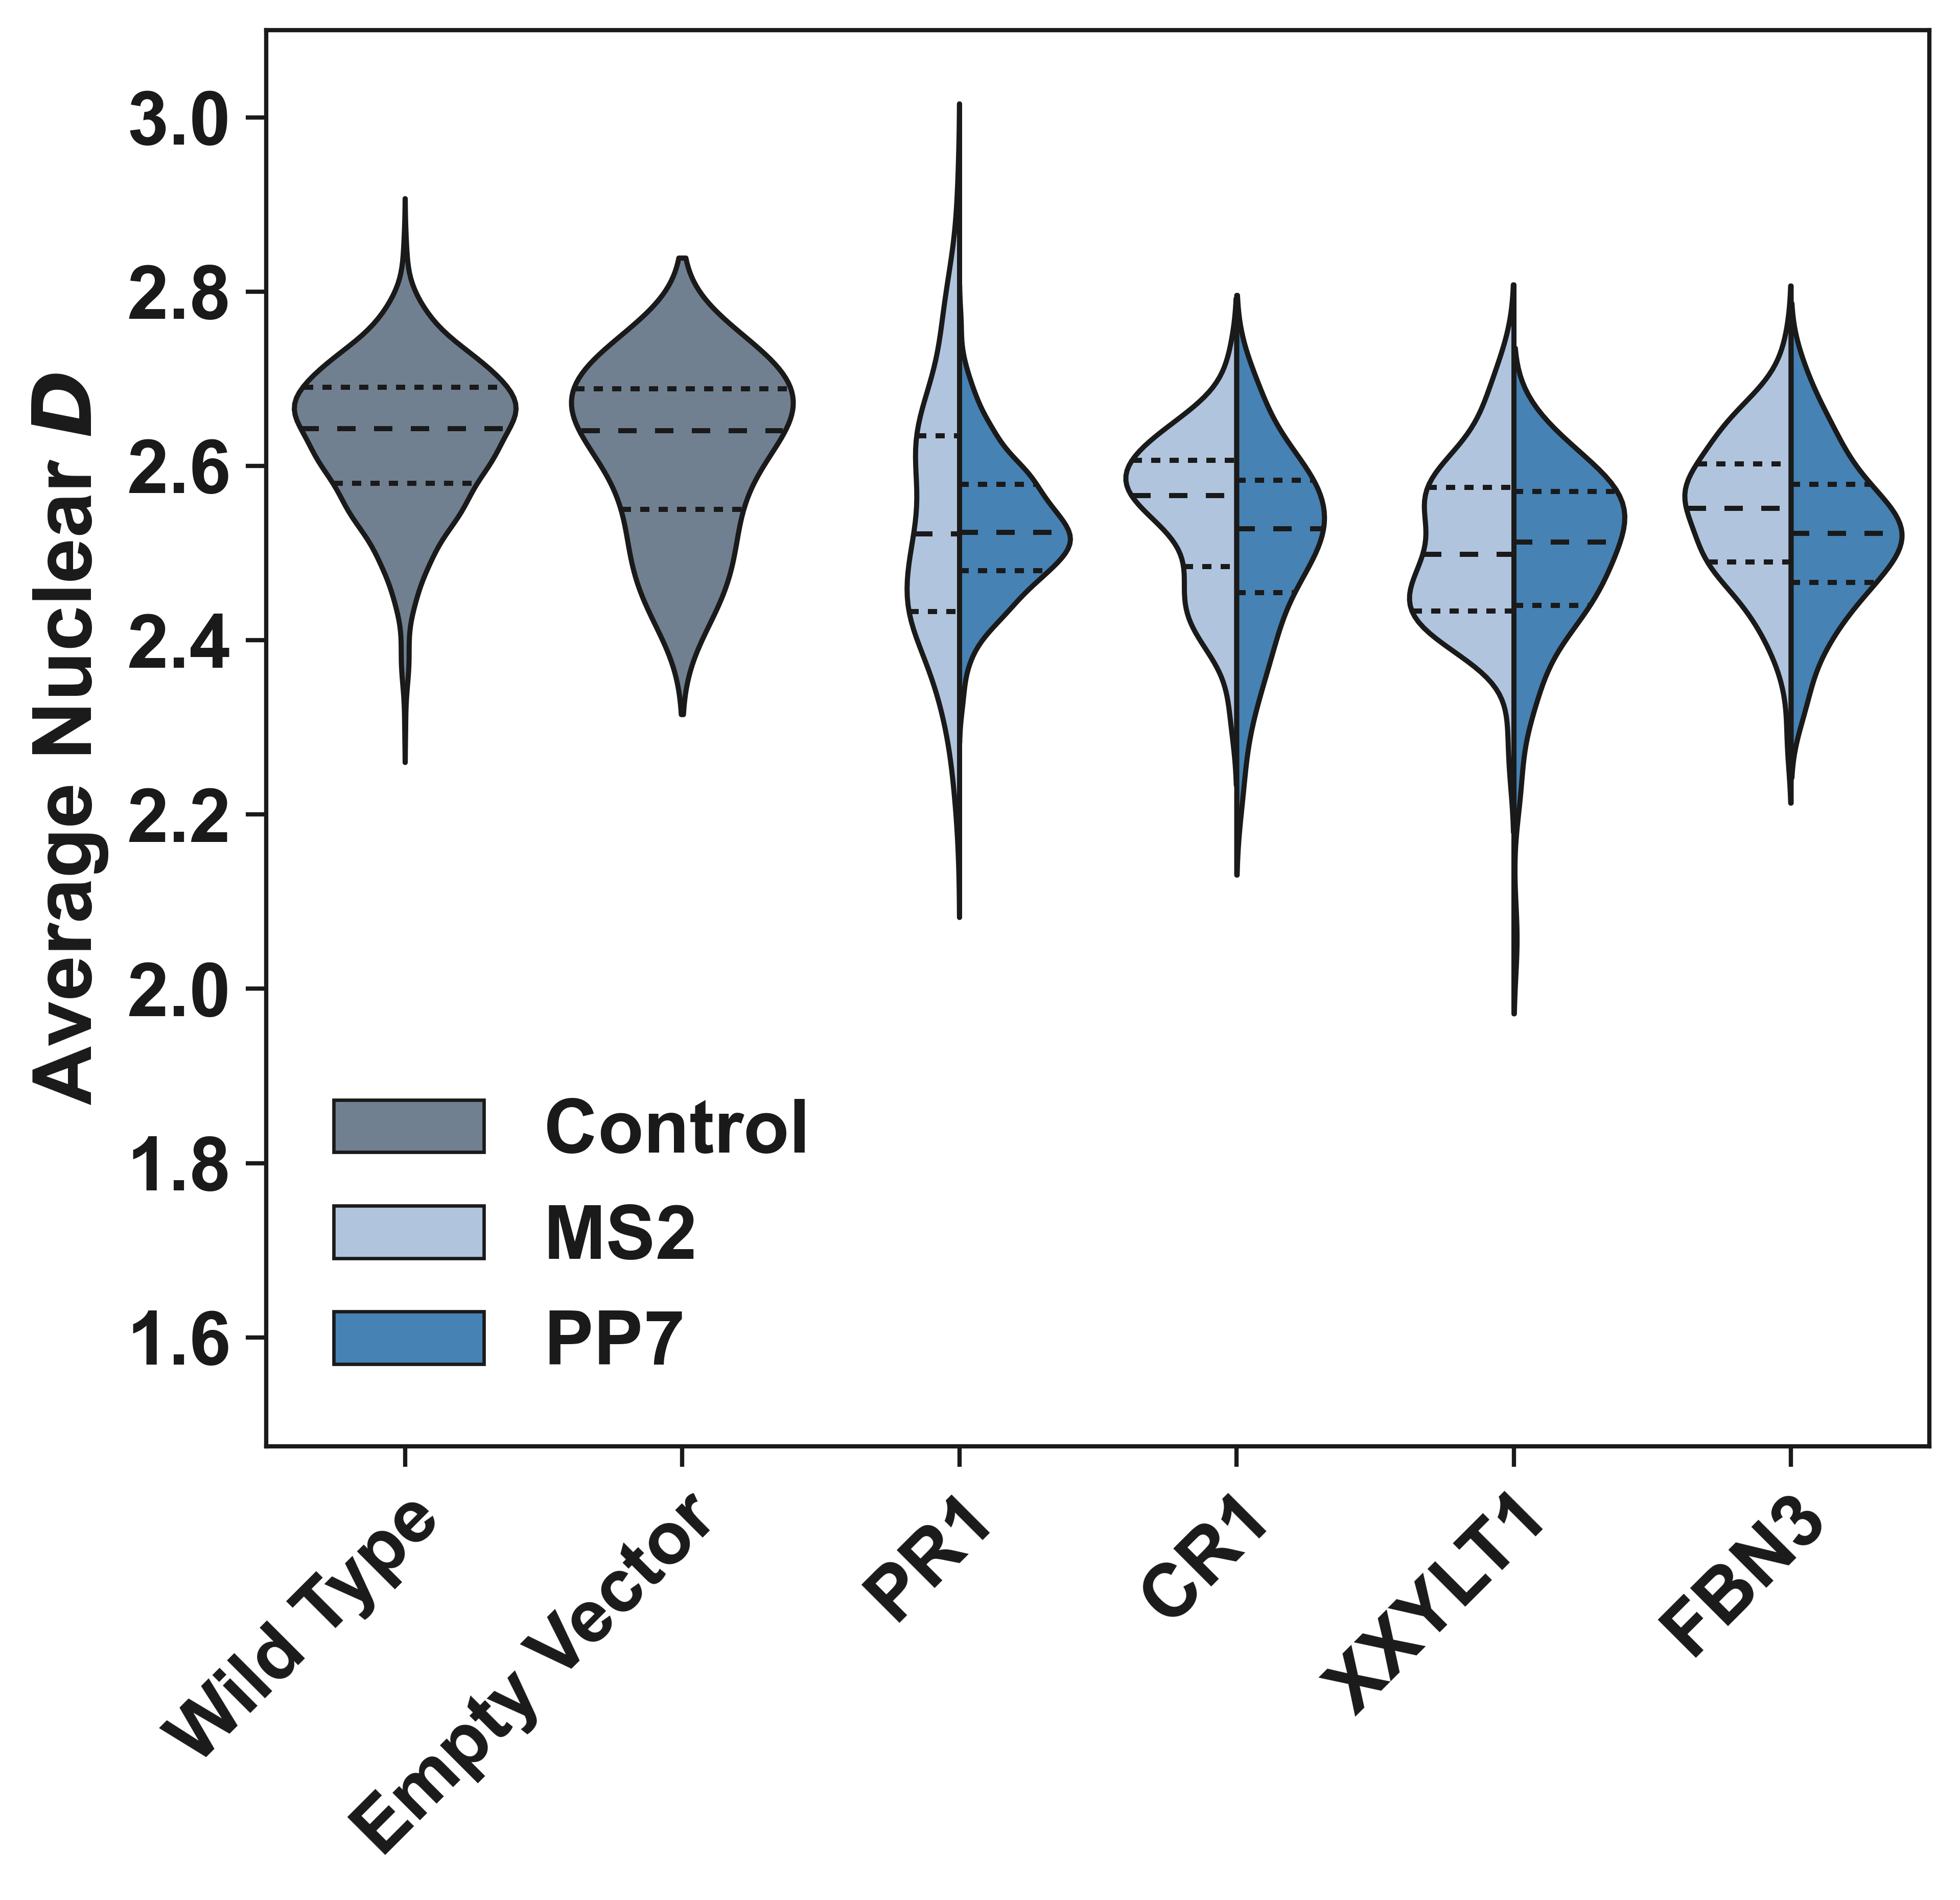

In [20]:
crispr_fig = all_data[all_data.Experiment=='CRISPR-Sirius Comparison'].copy()
crispr_fig['sgRNA'] = crispr_fig['Labeling Target']
crispr_fig.loc[crispr_fig['Labeling Target']=='No Label',
               'sgRNA'] = crispr_fig.loc[crispr_fig['Labeling Target']=='No Label','Condition']
crispr_fig['Aptamer'] = crispr_fig.Condition.str.split('-').str[1]
crispr_order = ['WT','Empty Vector','PR1','CR1','XXYLT1','FBN3']
crispr_fig['sgRNA'] = pd.Categorical(crispr_fig['sgRNA'],categories=crispr_order)
crispr_fig.sort_values('sgRNA',ignore_index=True,inplace=True)
crispr_pal = {'MS2':'lightsteelblue','PP7':'steelblue'}

split_plot = crispr_fig.copy()
split_plot.loc[(split_plot.Condition=='WT')|(split_plot.Condition=='Empty Vector'),'D'] = np.nan
split_plot.loc[(split_plot.Condition=='WT')|(split_plot.Condition=='Empty Vector'),'Aptamer'] = 'MS2'
crispr_labels = ['Wild Type','Empty Vector','PR1','CR1','XXYLT1','FBN3']

fig, ax = plt.subplots(figsize=[7,6])
sns.violinplot(data=crispr_fig[crispr_fig.Condition=='WT'],x='Condition',y='D',inner='quart',saturation=1,ax=ax,
              order=crispr_order,color=plot_pal['Live'])
sns.violinplot(data=crispr_fig[crispr_fig.Condition=='Empty Vector'],x='Condition',y='D',inner='quart',saturation=1,
               ax=ax,order=crispr_order,color=plot_pal['Live'])
sns.violinplot(data=split_plot,x='sgRNA',y='D',hue='Aptamer',split=True,inner='quart',saturation=1,
               ax=ax,palette=crispr_pal,order=crispr_order)
ax.set_xticklabels(crispr_labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylim(D_plot_lim)
ax.set_xlabel('')
ax.set_ylabel(r'Average Nuclear $D$')
l_h = [mpl.patches.Patch(facecolor='slategrey', edgecolor='k',label='Control'),
       mpl.patches.Patch(facecolor='lightsteelblue', edgecolor='k',label='MS2'),
       mpl.patches.Patch(facecolor='steelblue', edgecolor='k',label='PP7')]
legend = plt.legend(handles=l_h,title='',loc='lower left')

plt.show()
fig.savefig(save_dir+'\\CRISPR-Sirius PWS.pdf',dpi=600,transparent=True,bbox_inches='tight')

In [21]:
crispr_table_columns = ['sgRNA','N MS2','N PP7','Mean D MS2','Mean D PP7','STD D MS2','STD D PP7','WT Delta D MS2',
                        'WT Delta D PP7','Empty Vector Delta D MS2','Empty Vector Delta D PP7','Delta D Between',
                        'WT Percent Change MS2','WT Percent Change PP7','Empty Vector Percent Change MS2',
                        'Empty Vector Percent Change PP7','Percent Diff Between','WT Pval MS2','WT Pval Corr MS2',
                        'Empty Vector Pval MS2','Empty Vector Pval Corr MS2','WT Pval PP7','WT Pval Corr PP7',
                        'Empty Vector Pval PP7','Empty Vector Pval Corr PP7','Pval Between','Pval Corr Between']
crispr_table = pd.DataFrame(columns=crispr_table_columns)
crispr_table['sgRNA'] = crispr_fig.sgRNA.unique()

ms2 = crispr_fig[crispr_fig.Aptamer=='MS2'].copy()
ms2['sgRNA'] = pd.Categorical(ms2['sgRNA'],categories=crispr_fig.sgRNA.unique())
ms2.sort_values('sgRNA',ignore_index=True,inplace=True)
pp7 = crispr_fig[crispr_fig.Aptamer=='PP7'].copy()
pp7['sgRNA'] = pd.Categorical(pp7['sgRNA'],categories=crispr_fig.sgRNA.unique())
pp7.sort_values('sgRNA',ignore_index=True,inplace=True)

crispr_table['N MS2'] = ms2.groupby('sgRNA').describe()['D','count'].values.astype(int)
crispr_table['N PP7'] = pp7.groupby('sgRNA').describe()['D','count'].values.astype(int) 
crispr_table['Mean D MS2'] = ms2.groupby('sgRNA').describe()['D','mean'].values
crispr_table['Mean D PP7'] = pp7.groupby('sgRNA').describe()['D','mean'].values
crispr_table.loc[crispr_table.sgRNA=='WT',['N MS2','N PP7']] = crispr_fig.groupby('sgRNA').D.count()['WT']
crispr_table.loc[crispr_table.sgRNA=='WT',['Mean D MS2','Mean D PP7']] = crispr_fig.groupby('sgRNA').D.mean()['WT']
crispr_table.loc[crispr_table.sgRNA=='Empty Vector',
                 ['N MS2','N PP7']] = crispr_fig.groupby('sgRNA').D.count()['Empty Vector']
crispr_table.loc[crispr_table.sgRNA=='Empty Vector',
                 ['Mean D MS2','Mean D PP7']] = crispr_fig.groupby('sgRNA').D.mean()['Empty Vector']

ms2_ctrl = crispr_table.loc[crispr_table.sgRNA=='WT','Mean D MS2'].item()
pp7_ctrl = crispr_table.loc[crispr_table.sgRNA=='WT','Mean D PP7'].item()
ms2_empvec = crispr_table.loc[crispr_table.sgRNA=='Empty Vector','Mean D MS2'].item()
pp7_empvec = crispr_table.loc[crispr_table.sgRNA=='Empty Vector','Mean D PP7'].item()
crispr_table['STD D MS2'] = ms2.groupby('sgRNA').describe()['D','std'].values
crispr_table['STD D PP7'] = pp7.groupby('sgRNA').describe()['D','std'].values
crispr_table.loc[crispr_table.sgRNA=='WT',['STD D MS2','STD D PP7']] = crispr_fig.groupby('sgRNA').D.std()['WT']
crispr_table.loc[crispr_table.sgRNA=='Empty Vector',
                 ['STD D MS2','STD D PP7']] = crispr_fig.groupby('sgRNA').D.std()['Empty Vector']

crispr_table['WT Delta D MS2'] = crispr_table['Mean D MS2']-ms2_ctrl
crispr_table['WT Delta D PP7'] = crispr_table['Mean D PP7']-pp7_ctrl
crispr_table['Empty Vector Delta D MS2'] = crispr_table['Mean D MS2']-ms2_empvec
crispr_table['Empty Vector Delta D PP7'] = crispr_table['Mean D PP7']-pp7_empvec
crispr_table['Delta D Between'] = (crispr_table['Mean D MS2']-crispr_table['Mean D PP7']).abs()
crispr_table['WT Percent Change MS2'] = crispr_table['WT Delta D MS2']/ms2_ctrl*100
crispr_table['WT Percent Change PP7'] = crispr_table['WT Delta D PP7']/pp7_ctrl*100
crispr_table['Empty Vector Percent Change MS2'] = crispr_table['Empty Vector Delta D MS2']/ms2_empvec*100
crispr_table['Empty Vector Percent Change PP7'] = crispr_table['Empty Vector Delta D PP7']/pp7_empvec*100
crispr_table['Percent Diff Between'] = crispr_table['Delta D Between']/((crispr_table['Mean D MS2']+
                                                                         crispr_table['Mean D PP7'])/2)*100

crispr_comp = mc.MultiComparison(crispr_fig['D'], crispr_fig['Condition'])
tbl, a1, a2 = crispr_comp.allpairtest(stats.ttest_ind, method= 'bonf')
crispr_stats = pd.read_html(tbl.as_html(),header=0)[0]

ms2_stats = crispr_stats[((crispr_stats['group1']=='WT')|(crispr_stats['group2']=='WT'))&
                        ((crispr_stats['group1'].str.contains('MS2'))|
                         (crispr_stats['group2'].str.contains('MS2')))].copy()
ms2_stats.loc[crispr_stats['group1']!='WT',
                   ['group1','group2']] = ms2_stats.loc[crispr_stats['group1']!='WT',['group2','group1']].values
ms2_stats['group2'] = pd.Categorical(ms2_stats['group2'],categories=ms2.Condition.unique())
ms2_stats.sort_values('group2',ignore_index=True,inplace=True)

pp7_stats = crispr_stats[((crispr_stats['group1']=='WT')|(crispr_stats['group2']=='WT'))&
                        ((crispr_stats['group1'].str.contains('PP7'))|
                         (crispr_stats['group2'].str.contains('PP7')))].copy()
pp7_stats.loc[crispr_stats['group1']!='WT',
                   ['group1','group2']] = pp7_stats.loc[crispr_stats['group1']!='WT',['group2','group1']].values
pp7_stats['group2'] = pd.Categorical(pp7_stats['group2'],categories=pp7.Condition.unique())
pp7_stats.sort_values('group2',ignore_index=True,inplace=True)
crispr_table['WT Pval MS2'] = np.insert(pd.DataFrame(a1[0][ms2_stats.index])[1].values,[0,0],math.nan)
crispr_table['WT Pval PP7'] = np.insert(pd.DataFrame(a1[0][pp7_stats.index])[1].values,[0,0],math.nan)
crispr_table['WT Pval Corr MS2'] = np.insert(a1[2][ms2_stats.index],[0,0],math.nan)
crispr_table['WT Pval Corr PP7'] = np.insert(a1[2][pp7_stats.index],[0,0],math.nan)

ms2_stats = crispr_stats[((crispr_stats['group1']=='Empty Vector')|(crispr_stats['group2']=='Empty Vector'))&
                        ((crispr_stats['group1'].str.contains('MS2'))|
                         (crispr_stats['group2'].str.contains('MS2')))].copy()
ms2_stats.loc[crispr_stats['group1']!='Empty Vector',
                   ['group1','group2']] = ms2_stats.loc[crispr_stats['group1']!='Empty Vector',
                                                        ['group2','group1']].values
ms2_stats['group2'] = pd.Categorical(ms2_stats['group2'],categories=ms2.Condition.unique())
ms2_stats.sort_values('group2',ignore_index=True,inplace=True)
pp7_stats = crispr_stats[((crispr_stats['group1']=='Empty Vector')|(crispr_stats['group2']=='Empty Vector'))&
                        ((crispr_stats['group1'].str.contains('PP7'))|
                         (crispr_stats['group2'].str.contains('PP7')))].copy()
pp7_stats.loc[crispr_stats['group1']!='Empty Vector',
                   ['group1','group2']] = pp7_stats.loc[crispr_stats['group1']!='Empty Vector',
                                                        ['group2','group1']].values
pp7_stats['group2'] = pd.Categorical(pp7_stats['group2'],categories=pp7.Condition.unique())
pp7_stats.sort_values('group2',ignore_index=True,inplace=True)
crispr_table['Empty Vector Pval MS2'] = np.insert(pd.DataFrame(a1[0][ms2_stats.index])[1].values,[0,0],math.nan)
crispr_table['Empty Vector Pval PP7'] = np.insert(pd.DataFrame(a1[0][pp7_stats.index])[1].values,[0,0],math.nan)
crispr_table['Empty Vector Pval Corr MS2'] = np.insert(a1[2][ms2_stats.index],[0,0],math.nan)
crispr_table['Empty Vector Pval Corr PP7'] = np.insert(a1[2][pp7_stats.index],[0,0],math.nan)

pfa_ind = crispr_stats[((crispr_stats['group1']=='WT')|(crispr_stats['group2']=='WT'))&
                     ((crispr_stats['group1']=='Empty Vector')|(crispr_stats['group2']=='Empty Vector'))].index.item()
crispr_table.loc[crispr_table.sgRNA=='Empty Vector',['WT Pval MS2','WT Pval PP7']] = a1[0][pfa_ind][1]
crispr_table.loc[crispr_table.sgRNA=='Empty Vector',['WT Pval Corr MS2','WT Pval Corr PP7']] = a1[2][pfa_ind]

bet_ind = [crispr_stats[(crispr_stats['group1'].str.contains(cond))&
                        (crispr_stats['group2'].str.contains(cond))].index.item() 
           for cond in crispr_fig.sgRNA.unique() if (cond!='WT')&(cond!='Empty Vector')]
crispr_table['Pval Between'] = np.insert(pd.DataFrame(a1[0][bet_ind])[1].values,[0,0],math.nan)
crispr_table['Pval Corr Between'] = np.insert(a1[2][bet_ind],[0,0],math.nan)
print(crispr_table)
crispr_table.to_csv(save_dir+'\\Stats for CRISPR-Sirius sgRNA Comparison.csv',index=False)

          sgRNA  N MS2  N PP7  Mean D MS2  Mean D PP7  STD D MS2  STD D PP7  \
0            WT   1081   1081    2.632804    2.632804   0.083662   0.083662   
1  Empty Vector     41     41    2.616906    2.616906   0.095704   0.095704   
2           PR1    313    798    2.535919    2.529405   0.142329   0.073733   
3           CR1     88     89    2.544794    2.510674   0.086954   0.105332   
4        XXYLT1     80     80    2.509969    2.494303   0.092725   0.103022   
5          FBN3     84     86    2.546874    2.520093   0.084474   0.087449   

   WT Delta D MS2  WT Delta D PP7  Empty Vector Delta D MS2  ...  \
0        0.000000        0.000000                  0.015898  ...   
1       -0.015898       -0.015898                  0.000000  ...   
2       -0.096885       -0.103399                 -0.080986  ...   
3       -0.088010       -0.122130                 -0.072112  ...   
4       -0.122835       -0.138501                 -0.106936  ...   
5       -0.085930       -0.112711     

In [22]:
print(tbl)

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.00, alphacBonf=0.001
   group1       group2      stat    pval  pval_corr reject
----------------------------------------------------------
     CR1-MS2      CR1-PP7   2.3487   0.02     0.898  False
     CR1-MS2 Empty Vector  -4.2468    0.0    0.0019   True
     CR1-MS2     FBN3-MS2   -0.159 0.8738       1.0  False
     CR1-MS2     FBN3-PP7   1.8682 0.0634       1.0  False
     CR1-MS2      PR1-MS2   0.5561 0.5784       1.0  False
     CR1-MS2      PR1-PP7   1.8233 0.0686       1.0  False
     CR1-MS2           WT  -9.4614    0.0       0.0   True
     CR1-MS2   XXYLT1-MS2   2.5119  0.013    0.5834  False
     CR1-MS2   XXYLT1-PP7   3.4427 0.0007    0.0328   True
     CR1-PP7 Empty Vector  -5.4952    0.0       0.0   True
     CR1-PP7     FBN3-MS2  -2.4846 0.0139    0.6269  False
     CR1-PP7     FBN3-PP7  -0.6424 0.5214       1.0  False
     CR1-PP7      PR1-MS2   -1.556 0.1205       1.0  False
     CR1-PP7      PR1-

# RASER-FISH

In [23]:
# raser_fig = all_data[all_data.Experiment=='RASER-FISH'].copy()
# raser_fig['Scaled D'] = raser_fig['Normalized D']*raser_fig[raser_fig.Condition=='Live Control'].D.mean()
# raser_fig['Buffer'] = 'No Formamide'
# raser_fig.loc[raser_fig.Condition.str.contains('With Form'),'Buffer'] = 'With Formamide'
# raser_fig['Sample'] = raser_fig['Condition'].str.replace('With Form ','')
# raser_fig['Sample'] = raser_fig['Sample'].str.replace('No Form ','')
# raser_order = ['Live Control', 'Fixed Control','No Probe','No Probe BrdU','Chr19', 'Chr19 BrdU']
# raser_fig = raser_fig[raser_fig.Sample.isin(raser_order)]
# raser_fig['Sample'] = pd.Categorical(raser_fig['Sample'],raser_order)
# raser_fig.sort_values('Sample',ignore_index=True,inplace=True)
# raser_lab = ['Live Cells','Fixed Cells','No Probe + No BrdU/BrdC','No Probe','Chr 19 Probe + No BrdU/BrdC','Chr 19 Probe']
# raser_pal = {'No Formamide':'lightsteelblue','With Formamide':'steelblue'}

# split_plot = raser_fig.copy()
# split_plot.loc[(split_plot.Condition=='Live Control')|(split_plot.Condition=='Fixed Control'),'D'] = np.nan

# fig, ax = plt.subplots(figsize=[7,6])
# sns.violinplot(data=raser_fig[raser_fig.Condition=='Live Control'],x='Condition',y='D',inner='quart',saturation=1,ax=ax,
#               order=raser_order,color=plot_pal['Live'])
# sns.violinplot(data=raser_fig[raser_fig.Condition=='Fixed Control'],x='Condition',y='D',inner='quart',saturation=1,ax=ax,
#               order=raser_order,color=plot_pal['Live'])
# sns.violinplot(data=split_plot,x='Sample',y='D',hue='Buffer',split=True,inner='quart',saturation=1,
#                ax=ax,palette=raser_pal)

# ax.set_xticklabels(raser_lab, rotation=45, ha='right', rotation_mode='anchor')
# ax.set_ylim([1.525,3.275])
# ax.yaxis.set_ticks(np.arange(1.6, 3.4, 0.2))
# ax.set_xlabel('')
# ax.set_ylabel(r'Average Nuclear $D$')

# plt.show()
# fig.savefig(save_dir+'\\RASER-FISH PWS.pdf',dpi=600,transparent=True,bbox_inches='tight')

In [24]:
# raser_fig = all_data[all_data.Experiment=='RASER-FISH'].copy()
# raser_fig['Scaled D'] = raser_fig['Normalized D']*raser_fig[raser_fig.Condition=='Live Control'].D.mean()
# raser_fig['Buffer'] = 'No Formamide'
# raser_fig.loc[raser_fig.Condition.str.contains('With Form'),'Buffer'] = 'With Formamide'
# raser_fig['Sample'] = raser_fig['Condition'].str.replace('With Form ','')
# raser_fig['Sample'] = raser_fig['Sample'].str.replace('No Form ','')
# raser_order = ['Live Control', 'Fixed Control','No Probe','No Probe BrdU','Chr19', 'Chr19 BrdU']
# raser_fig = raser_fig[raser_fig.Sample.isin(raser_order)]
# raser_fig['Sample'] = pd.Categorical(raser_fig['Sample'],raser_order)
# raser_fig.sort_values('Sample',ignore_index=True,inplace=True)
# raser_lab = ['Live Cells','Fixed Cells','No Probe + No BrdU/BrdC','No Probe','No Probe + No BrdU/BrdC','Chr 19 Probe']
# raser_pal = {'No Formamide':'lightsteelblue','With Formamide':'steelblue'}

# split_plot = raser_fig.copy()
# split_plot.loc[(split_plot.Condition=='Live Control')|(split_plot.Condition=='Fixed Control'),'D'] = np.nan

# fig, ax = plt.subplots(figsize=[7,6])
# sns.violinplot(data=raser_fig[raser_fig.Condition=='Live Control'],x='Condition',y='D',inner='quart',saturation=1,ax=ax,
#               order=raser_order,color=plot_pal['Live'])
# sns.violinplot(data=raser_fig[raser_fig.Condition=='Fixed Control'],x='Condition',y='D',inner='quart',saturation=1,ax=ax,
#               order=raser_order,color=plot_pal['Live'])
# sns.violinplot(data=split_plot,x='Sample',y='D',hue='Buffer',split=True,inner='quart',saturation=1,
#                ax=ax,palette=raser_pal)

# ax.set_xticklabels(raser_lab, rotation=45, ha='right', rotation_mode='anchor')
# ax.set_ylim([1.45,3.4])
# ax.yaxis.set_ticks(np.arange(1.6, 3.4, 0.2))
# ax.set_xlabel('')
# ax.set_ylabel(r'Average Nuclear $D$')

# plt.show()
# fig.savefig(save_dir+'\\RASER-FISH PWS.pdf',dpi=600,transparent=True,bbox_inches='tight')

In [25]:
# l_h = [mpl.patches.Patch(facecolor='slategrey', edgecolor='k',label='Fixed Cells'),
#        mpl.patches.Patch(facecolor='lightsteelblue', edgecolor='k',label='No BrdU/BrdC'),
#        mpl.patches.Patch(facecolor='steelblue', edgecolor='k',label='With BrdU/BrdC')]
# legend = plt.legend(handles=l_h,title='')
# fig = legend.figure
# fig.canvas.draw()
# bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig(save_dir+'\\RASER-FISH PWS Legend.pdf',dpi=600,transparent=True,bbox_inches=bbox)

In [26]:
# raser_table = pd.DataFrame(columns=['Condition','N','Mean D','STD D','Delta D','Percent Change','Pval','Pval Corr'])
# raser_table['Condition'] = raser_fig.Condition.unique()
# raser_table['N'] = raser_fig.groupby('Condition').describe()['D','count'].values.astype(int)
# raser_table['Mean D'] = raser_fig.groupby('Condition').describe()['D','mean'].values
# raser_table['STD D'] = raser_fig.groupby('Condition').describe()['D','std'].values

# raser_ctrl = raser_table.loc[raser_table.Condition=='No Probe & No BrdU/BrdC','Mean D'].item()
# raser_table['Delta D'] = raser_table['Mean D']-raser_ctrl
# raser_table['Percent Change'] = raser_table['Delta D']/raser_ctrl*100

# raser_comp = mc.MultiComparison(raser_fig['D'], raser_fig['Condition'])
# tbl, a1, a2 = raser_comp.allpairtest(stats.ttest_ind, method= 'bonf')
# raser_stats = pd.read_html(tbl.as_html(),header=0)[0]
# raser_fig_stats = raser_stats[(raser_stats['group1']=='No Probe & No BrdU/BrdC')|
#                               (raser_stats['group2']=='No Probe & No BrdU/BrdC')].copy()
# raser_fig_stats['group1'] = pd.Categorical(raser_fig_stats['group1'],categories=raser_fig.Condition.unique())
# raser_fig_stats.sort_values('group1',ignore_index=True,inplace=True)

# raser_table['Pval'] = np.insert(pd.DataFrame(a1[0][raser_fig_stats.index])[1].values,0,math.nan)
# raser_table['Pval Corr'] = np.insert(a1[2][raser_fig_stats.index],0,math.nan)
# print(raser_table)
# raser_table.to_csv(save_dir+'\\RASER-FISH_Stats.csv',index=False)

In [27]:
# print(tbl)

# Labeling Efficiency

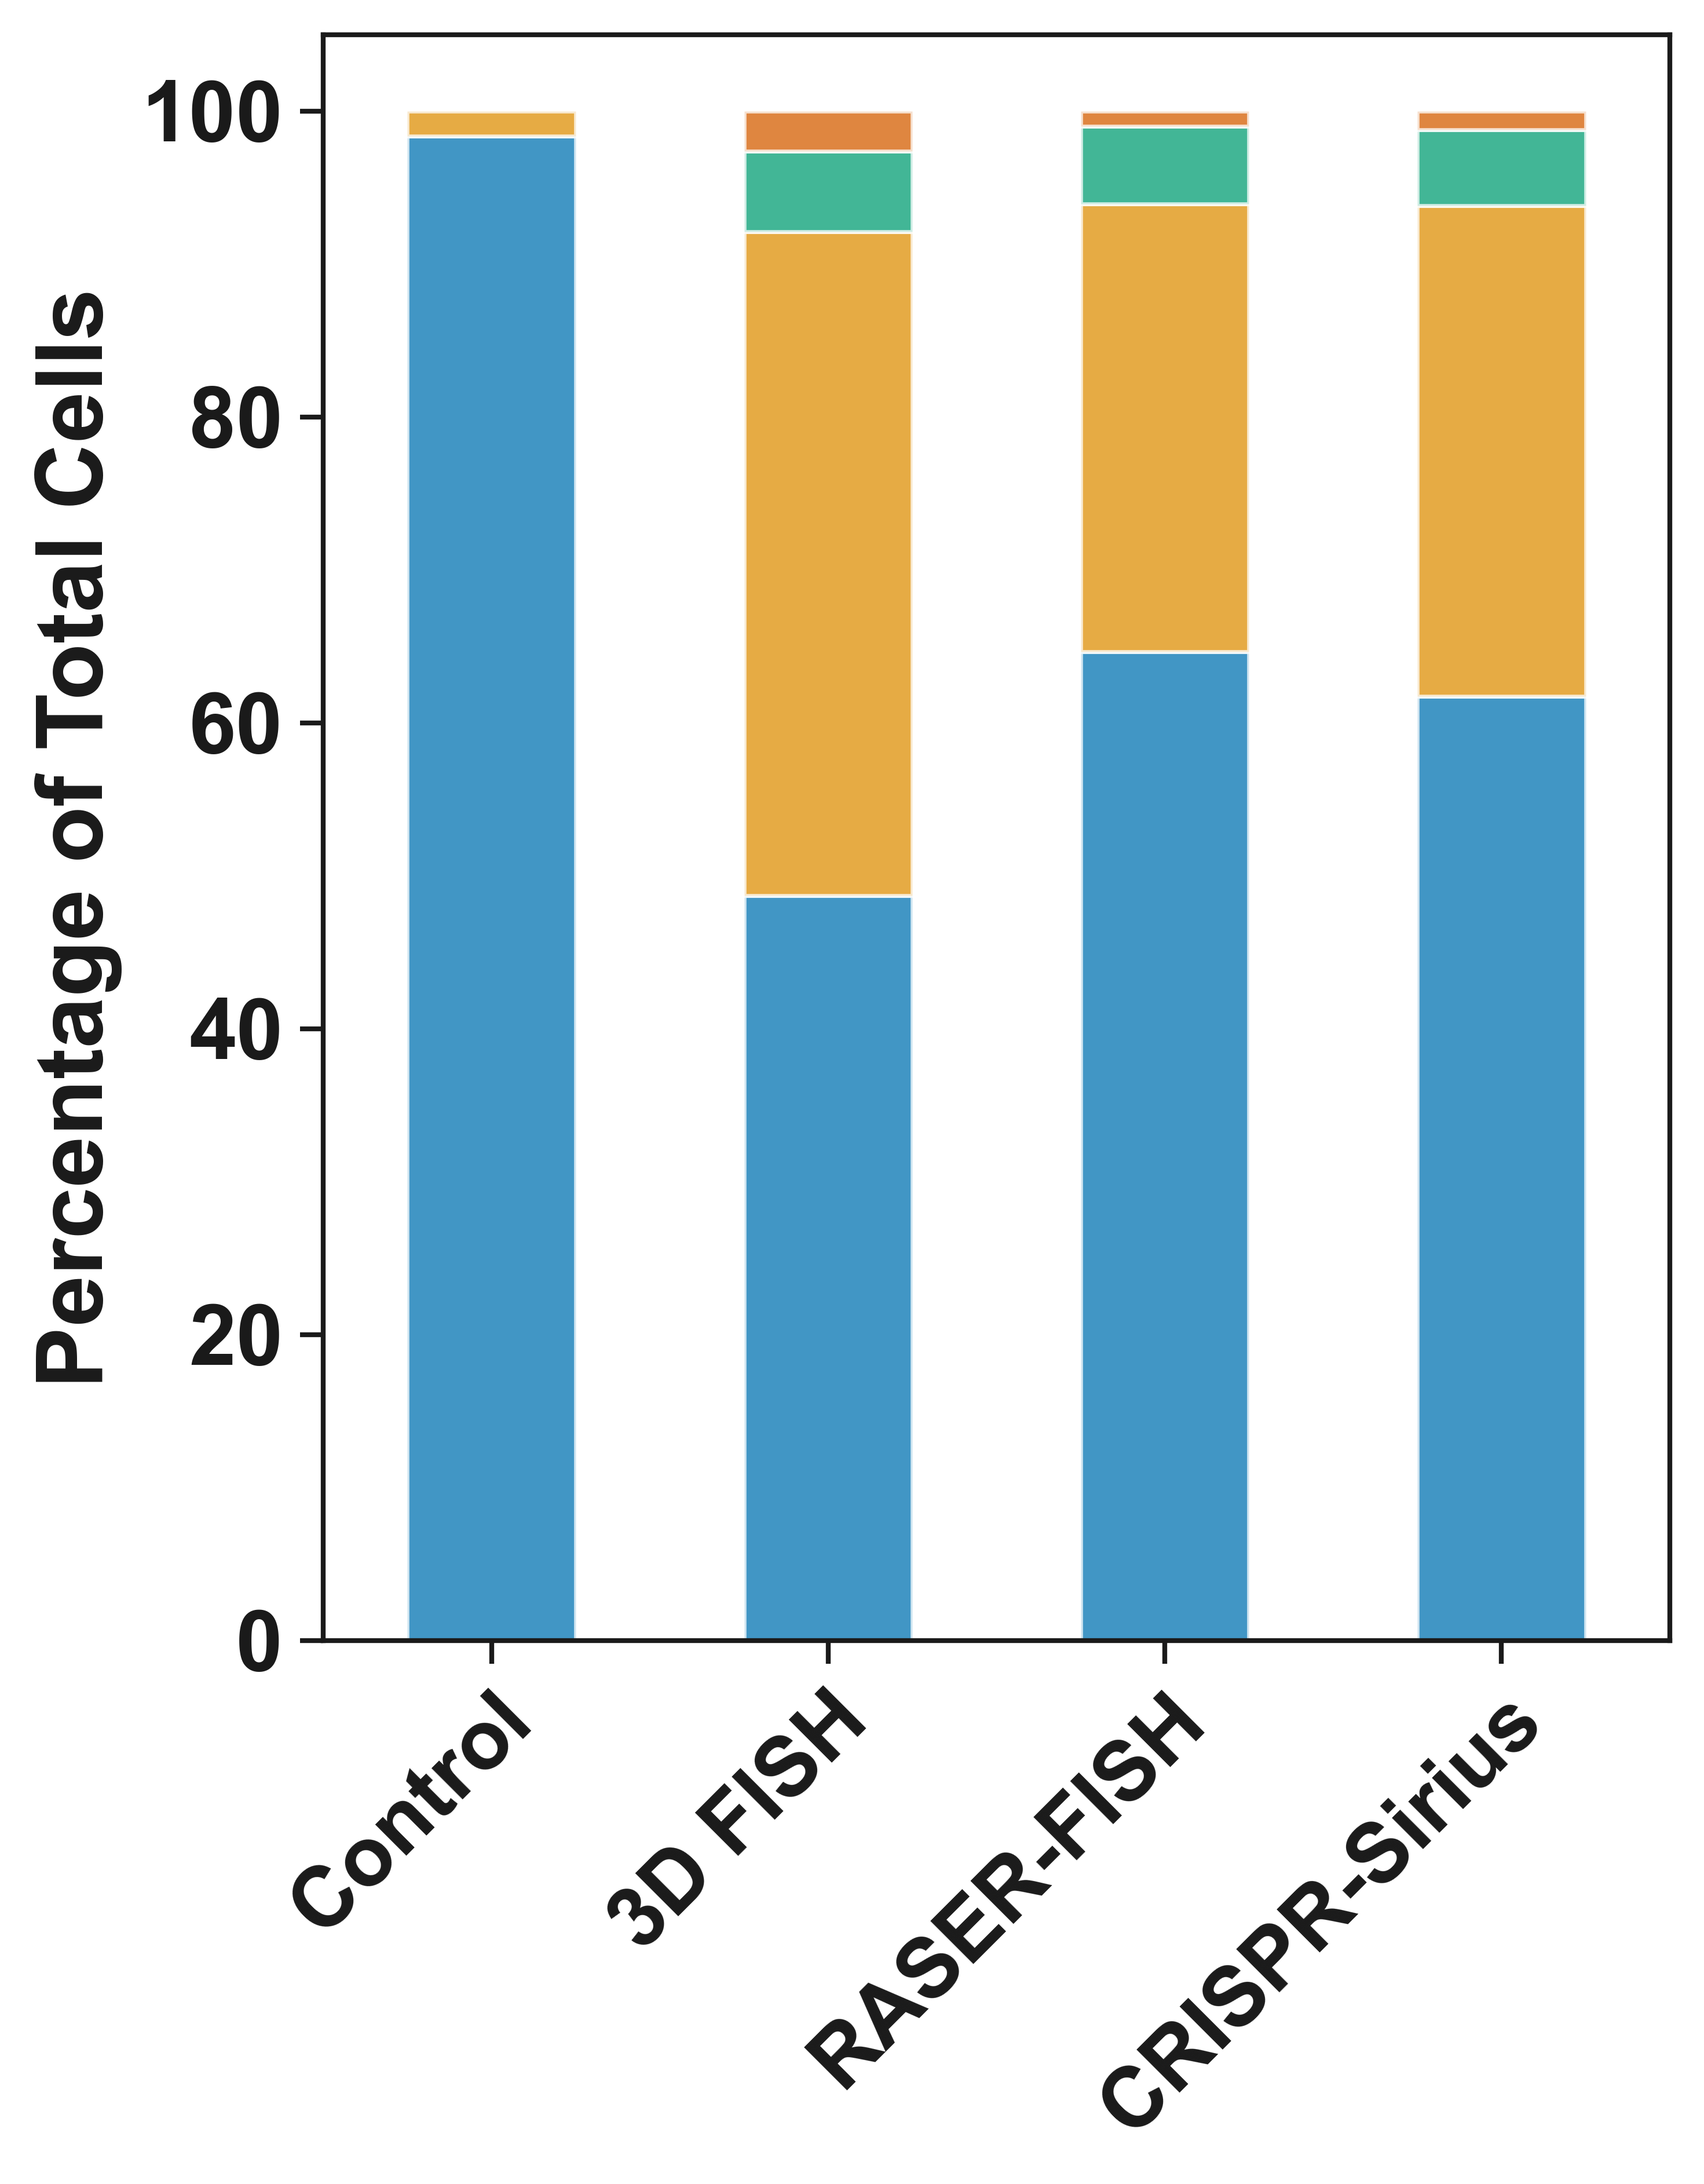

In [28]:
fociplot = all_foci[~all_foci.Condition.str.contains('Mock')&~all_foci.Condition.str.contains('Empty')].copy()
fociplot['Sample'] = fociplot['Labeling Protocol']
fociplot.loc[fociplot.Condition.str.contains('Control'),'Sample'] = 'Control'
foci_order = ['Control','3D FISH','RASER-FISH','CRISPR-Sirius']
fociplot['Sample'] = pd.Categorical(fociplot['Sample'],foci_order)
foci_nums = fociplot.groupby('Sample')['NumFoci'].value_counts(normalize=True)*100

fig, ax = plt.subplots(figsize=[5,6])
foci_nums.unstack('NumFoci').plot.bar(stacked=True,alpha=0.75,ax=ax)
ax.set_xticklabels(foci_order, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('')
ax.set_ylabel('Percentage of Total Cells')
l_h, l_l = ax.get_legend_handles_labels()
ax.get_legend().remove()

plt.show()
fig.savefig(save_dir+'\\Labeling Efficiency.pdf',dpi=600,transparent=True,bbox_inches='tight')

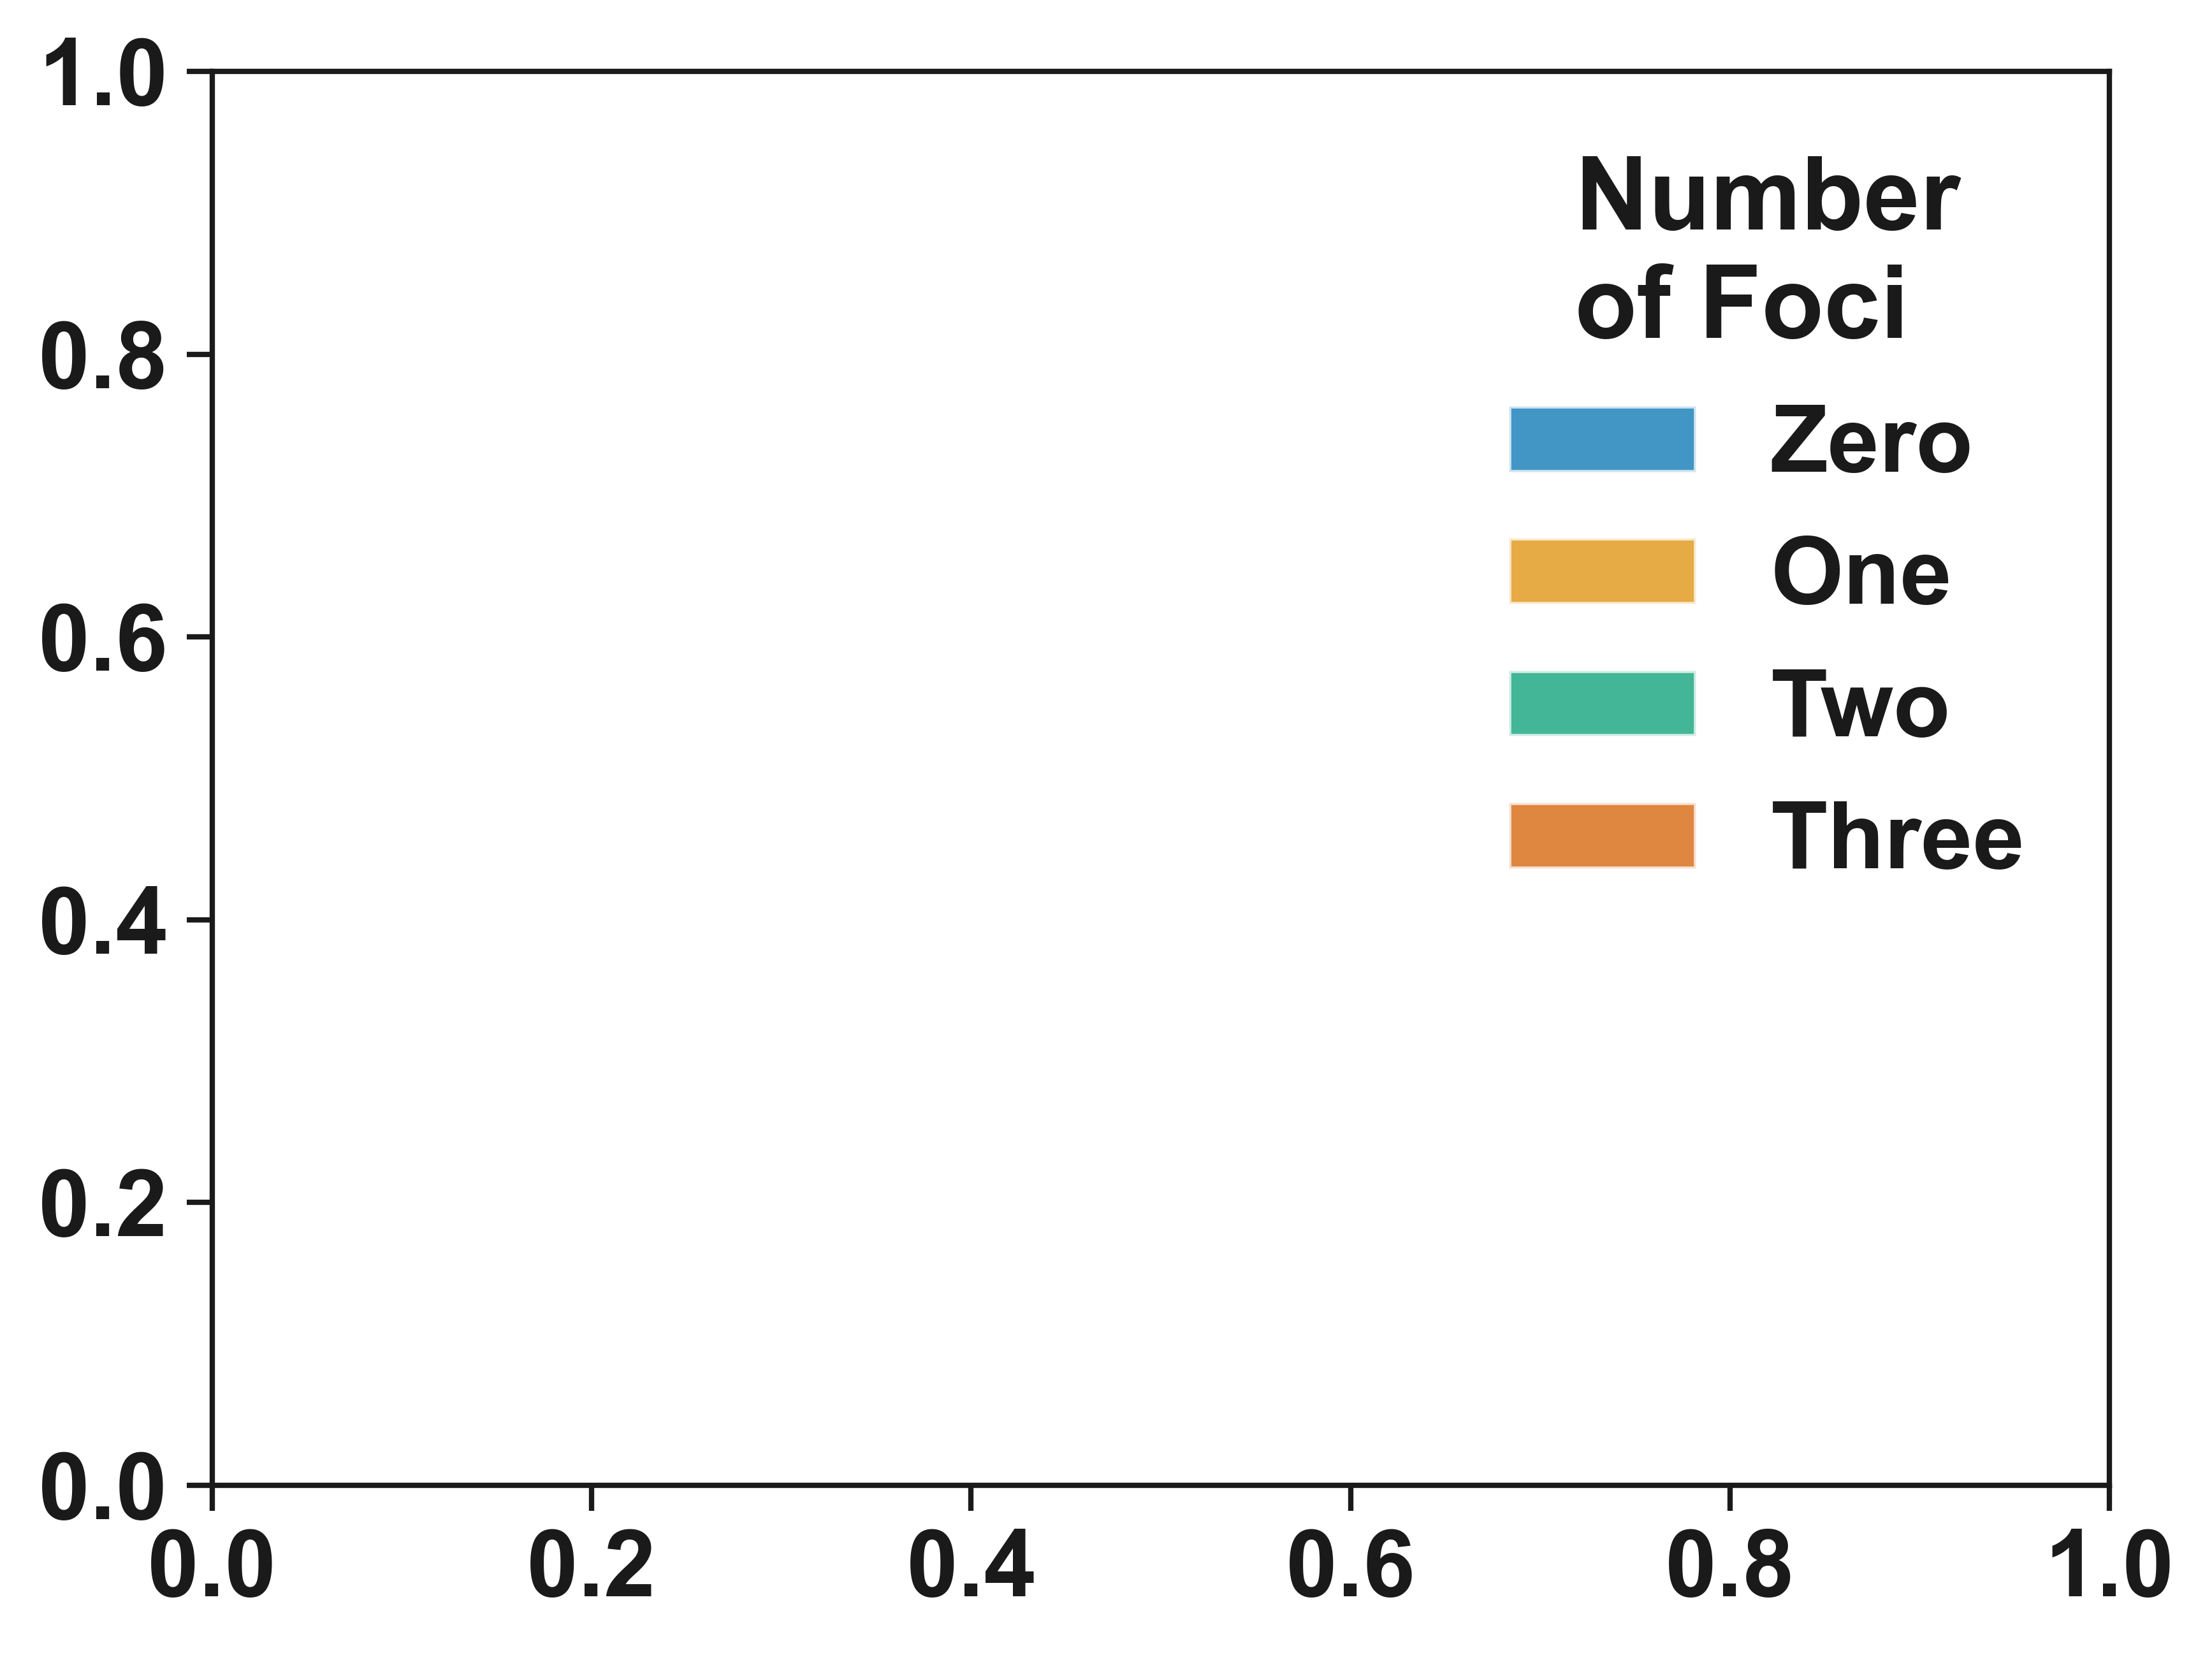

In [29]:
foci_legend_labels = ['Zero','One','Two','Three']
legend = plt.legend(handles=l_h,labels=foci_legend_labels,title='Number\nof Foci')
fig = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(save_dir+'\\Labeling Efficiency Legend.pdf',dpi=600,transparent=True,bbox_inches=bbox)

In [30]:
foci_table = pd.DataFrame(columns=['Sample','Nuclei#','#Cells with Foci','%Cells with Foci','#Cells with 3 Foci',
                                   '%Cells with 3 Foci'])
foci_table['Sample'] = foci_order
foci_table['Nuclei#'] = fociplot.groupby('Sample').Sample.count().values
foci_table['#Cells with Foci'] = fociplot[fociplot.NumFoci>0].groupby('Sample').Sample.count().values
foci_table['%Cells with Foci'] = foci_table['#Cells with Foci']/foci_table['Nuclei#']*100
foci_table['#Cells with 3 Foci'] = fociplot[fociplot.NumFoci>2].groupby('Sample').Sample.count().values
foci_table['%Cells with 3 Foci'] = foci_table['#Cells with 3 Foci']/foci_table['Nuclei#']*100
print(foci_table)
foci_table.to_csv(save_dir+'\\Stats for Foci Analysis.csv',index=False)

          Sample  Nuclei#  #Cells with Foci  %Cells with Foci  \
0        Control       61                 1          1.639344   
1        3D FISH       76                39         51.315789   
2     RASER-FISH       99                35         35.353535   
3  CRISPR-Sirius       81                31         38.271605   

   #Cells with 3 Foci  %Cells with 3 Foci  
0                   0            0.000000  
1                   2            2.631579  
2                   1            1.010101  
3                   1            1.234568  


# CRISPR-Sirius Transduction Efficiency

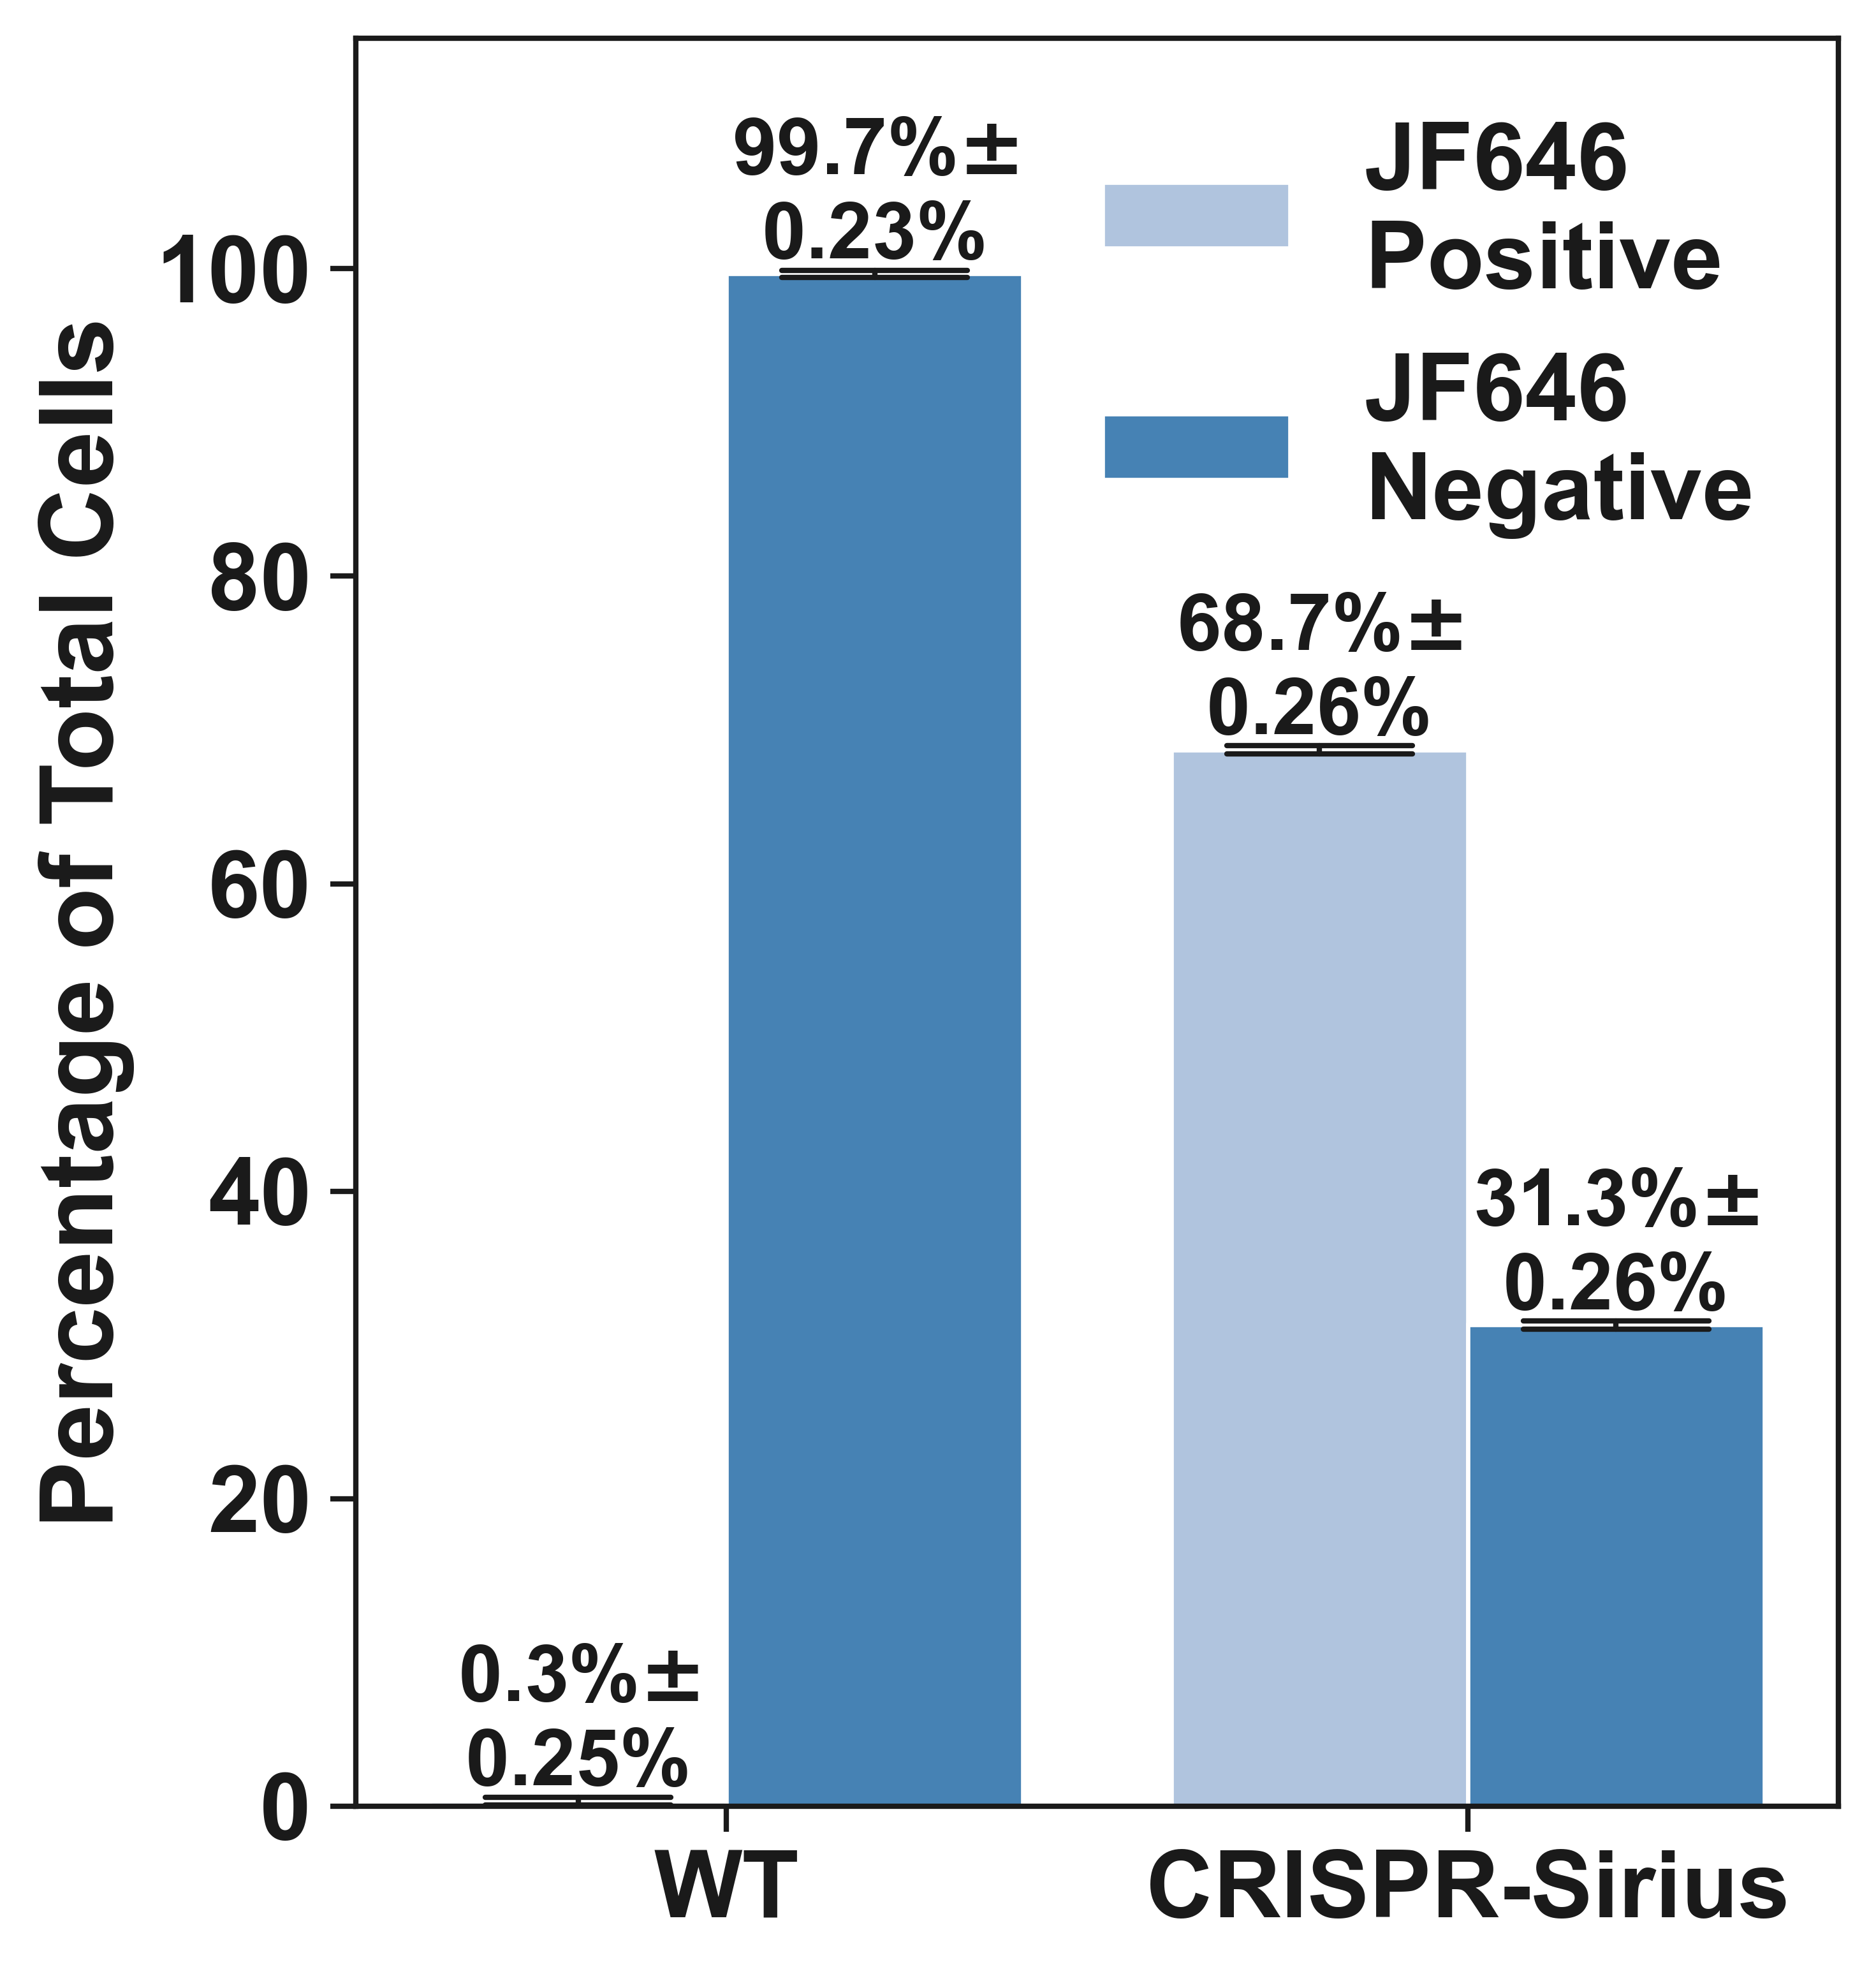

In [31]:
eff_red = all_eff[all_eff['Cell Type'].str.contains('APC-A')].copy()
eff_order = ['WT','CRISPR-Sirius']
eff_red['Condition'] = pd.Categorical(eff_red['Condition'],eff_order)
eff_pal = {'APC-A+':'lightsteelblue','APC-A-':'steelblue'}
eff_means = eff_red.groupby(['Condition','Cell Type']).Statistic.mean()
eff_sem = eff_red.groupby(['Condition','Cell Type']).Statistic.sem()
barlab = [f'{val:.1f}%$\pm$\n{e:.2f}%' for val,e in zip(eff_means.values,eff_sem.values)]

fig, ax = plt.subplots(figsize=[5,6])
sns.barplot(data=eff_red,x='Condition',y='Statistic',hue='Cell Type',order=eff_order,palette=eff_pal,saturation=1,
            errorbar='se',capsize=0.25,errwidth=1,errcolor='k')
for num,container in enumerate(ax.containers):
    ax.bar_label(container, labels=[barlab[num],barlab[num+2]], fontsize=15)
ax.set_ylim([0,115])
ax.set_xlabel('')
ax.set_ylabel('Percentage of Total Cells')
l_h = [mpl.patches.Patch(facecolor='lightsteelblue', label='JF646\nPositive'),
       mpl.patches.Patch(facecolor='steelblue', label='JF646\nNegative')]
legend = plt.legend(handles=l_h,title='')

plt.show()
fig.savefig(save_dir+'\\CRISPR-Sirius Transduction Efficiency.pdf',dpi=600,transparent=True,bbox_inches='tight')

In [32]:
eff_red.groupby(['Condition'])['#Cells'].sum()

Condition
WT               80072
CRISPR-Sirius    68843
Name: #Cells, dtype: int64

In [33]:
import sys
sys.float_info 

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)